#### Importing Libraries

In [8]:
import warnings
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import math
import joblib
from sklearn.metrics import mean_squared_error, mean_pinball_loss, r2_score, classification_report, confusion_matrix, mean_absolute_percentage_error
from imblearn.over_sampling import SMOTENC
import lightgbm as lgb
import json


#### Constants

In [9]:
PATH_TO_CVS = 'output/output-energy/'
GROUP_FILE_PATH = 'group_list.json'
# This constant contains the unique quantile to represent in the scatter plot of residuals 
ONLY_QUANTILE = 0.95
# Constant containing the partial name of all the metric of a function
FUNCTION_COLUMNS = ['rate_function_', 'success_rate_function_', 'cpu_usage_function_', 'ram_usage_function_', 'power_usage_function_', 'replica_', 'overloaded_function_', 'medium_latency_function_']
# A selection of node metrics to represent in the boxplot and in the scatter plot 
COL_TO_PLOT = ['cpu_usage_idle_node', 'cpu_usage_node', 'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node', 'power_usage_node']
# List containing the values whose quantile regression is to be calculated
QUANTILES = [0.05, 0.95]
NODE_TYPES = ["LIGHT", "MID", "HEAVY"]

#### Utilities functions

In [10]:
# Function used to fill NaN values within the dataframe X
def fill_NaN(X):
  for col in X:
    if(col.startswith('success_rate_')):
      X.loc[:, col] = X.loc[:, col].fillna(1)
    else:
      X.loc[:, col] = X.loc[:, col].fillna(0)
  return X

In [11]:
# Function to reweight of dataframe
def resample_dataset(X, y):
  X_resampled, y_resampled = resample(X, y, replace=True, random_state=42)
  return X_resampled, y_resampled

In [12]:
# Function used to split the dataset into training and test set
def split_dataset(X, y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
  return X_train, X_test, y_train, y_test

In [13]:
def convert_dataset(X_train, X_test, y_train, y_test):
  X_train_nn = X_train.astype(np.float32)
  X_test_nn = X_test.astype(np.float32)
  y_train_nn = y_train.astype(np.float32)
  y_test_nn = y_test.astype(np.float32)
  
  return X_train_nn, X_test_nn, y_train_nn, y_test_nn

In [14]:
# Function used to calculate the weighted mean squared error
def wmse_score(y_true, y_pred):
  # Calculates the weight of classes for the first target  
  median_cpu = y_true['cpu_usage_node'].median()
  w_majority_cpu = y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] / y_true.shape[0]
  w_minority_cpu = y_true[y_true['cpu_usage_node'] > median_cpu].shape[0] / y_true.shape[0]

  # Calculate the weight of classes for the second target
  median_ram = y_true['ram_usage_node'].median()
  w_majority_ram = y_true[y_true['ram_usage_node'] <= median_ram].shape[0] / y_true.shape[0]
  w_minority_ram = y_true[y_true['ram_usage_node'] > median_ram].shape[0] / y_true.shape[0]

  # Calculates the MSE for both targets
  mse_cpu = mean_squared_error(y_true['cpu_usage_node'], y_pred['cpu_usage_node'])
  mse_ram = mean_squared_error(y_true['ram_usage_node'], y_pred['ram_usage_node'])

  # Calculates WMSE as a weighted average of the MSEs for the two targets
  wmse = (w_majority_cpu * mse_cpu * y_true.shape[0] / (w_majority_cpu * y_true[y_true['cpu_usage_node'] <= median_cpu].shape[0] + w_minority_cpu * y_true[y_true['cpu_usage_node'] > median_cpu].shape[0]) +
          w_majority_ram * mse_ram * y_true.shape[0] / (w_majority_ram * y_true[y_true['ram_usage_node'] <= median_ram].shape[0] + w_minority_ram * y_true[y_true['ram_usage_node'] > median_ram].shape[0])) / 2

  return wmse

In [15]:
# Function used to calculate metrics based on the task
def metrics(task_type, y_test, y_pred, quantile):
  if(task_type == 'regression'):
    mape = mean_absolute_percentage_error(y_test, y_pred)
    print("mape:", mape)
    mse = mean_squared_error(y_test, y_pred)
    print("mse:", mse)
    rmse = math.sqrt(mse)
    print("rmse:", rmse)
    r2 = r2_score(y_test, y_pred)
    print("R-squared score:", r2)
    std_dev = float(np.std(y_pred))
    print("Standard deviation:", std_dev)
    if quantile != 0:
      quantile_loss = mean_pinball_loss(y_test, y_pred, alpha=quantile)
      print("Quantile loss with library: ", quantile_loss)
    else:
      quantile_loss = "Not calculated for this target"
    return {"mape": mape, "mse": mse, "rmse": rmse, "r2": r2, "quantile_loss": quantile_loss, "std_dev": std_dev}    
  elif(task_type.endswith('classification')):
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    return {}

In [16]:
# Function used to plot the regression lines for the 2 targets
def plot_regression(y_test, y_pred, target_name):
  # Calculate the regression lines
  m, q = np.polyfit(y_test.ravel(), y_pred.ravel(), 1)

  # Plot the regression lines
  plt.plot(y_test, y_pred, 'o', color='red', fillstyle='none')
  plt.plot(y_test, m*y_test + q, linestyle='--')
  plt.xlabel('Valori osservati')
  plt.ylabel('Valori predetti')
  plt.title('Regressione di ' + target_name)
  plt.xlim(0, 1) 
  plt.ylim(0, 1)  
  plt.show()

  # Calculate residuals
  residuals = y_test.flatten() - y_pred.flatten()

  # Scatter plot with regression line
  sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Osservazioni')

  # Add the horizontal line near the value 0.0 of the y-axis
  plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
  plt.xlabel('Valori osservati')
  plt.ylabel('Residui (Valori osservati - Valori predetti)')
  plt.title(f'Regressione Standard - {target_name}')
  plt.legend()
  plt.show()

In [17]:
# Function used to plots quantile regression results.
def plot_quantile_regression(y_test, y_pred, target_name):    
    point = 1
    line = 3
    for col in y_pred:
        m, q = np.polyfit(y_test.ravel(), y_pred[col], 1)
        plt.plot(y_test, y_pred[col], 'o', fillstyle='none', label=f'Osservazioni - {col}')
        plt.plot(y_test, m*y_test + q, linestyle='--', zorder = line)
        point = point + 1
        line = line + 1
    plt.xlabel('Valori osservati')
    plt.ylabel('Valori predetti')
    plt.title('Regressione Quantile di ' + target_name)
    plt.xlim(0, 1)  
    plt.ylim(0, 1)  
    plt.legend()
    plt.show()

    # Calculate quantile residuals
    residuals = y_test.flatten() - y_pred[str(ONLY_QUANTILE)]

    # Scatter plot with regression line
    sns.scatterplot(x=y_test.flatten(), y=residuals, label=f'Osservazioni')

    # Add the horizontal line near the value 0.0 of the y-axis
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Valori osservati')
    plt.ylabel('Residui quantili (Valori osservati - Valori predetti)')
    plt.title(f'Regressione Quantile {ONLY_QUANTILE} - {target_name}')
    plt.legend()
    plt.show()

In [18]:
# Function used to plot the confusion matrix
def plot_confusion_matrix(y_test, y_pred, target):
  # Calculate the confusion matrix
  cm = confusion_matrix(y_test[target], y_pred[target])

  # Plot the confusion matrix as heatmap
  sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
  plt.xlabel('Valori osservati')
  plt.ylabel('Valori predetti')
  plt.title('Confusion matrix')
  plt.show()

In [19]:
# Function used to train the desired model for a target variable
def train_model(target_name, X_train, y_train, quantile):
    # Classification task. Create model with autogluon
    if target_name.startswith('overloaded') or target_name.startswith('replica'):
        model_type = ""
        model = lgb.LGBMClassifier()
    # Quantile regression with LGBM
    elif quantile != 0:
        model = lgb.LGBMRegressor(objective='quantile', alpha=quantile)
        model_type = "quantile" + str(quantile).replace('.', '')
    # Regression with LGBM
    else:
        model = lgb.LGBMRegressor(objective='regression')
        model_type = "regression"
    
    model.fit(X_train, y_train)
    path = './system-forecaster-models/groups/' + target_name + "/" + model_type
    if not os.path.exists(path):
        os.makedirs(path)
    joblib.dump(model, path + "/model.joblib")

    return model



In [20]:
# Function to obtain a barchart of the type of nodes
def plot_node_type_distribution(df):
    """
    Visualizza il numero di dati per ogni tipologia di nodo in un DataFrame tramite un bar chart.

    :param df: DataFrame contenente la colonna 'node_type' con le tipologie di nodo.
    """
    # Count of occurrences for each node type
    node_counts = df['node_type'].value_counts()

    # Bar chart
    plt.figure(figsize=(10, 6))
    node_counts.plot(kind='bar')
    plt.title('Distribuzione del Numero di Dati per Tipologia di Nodo')
    plt.xlabel('Tipologia di Nodo (0 = Heavy, 1 = Mid, 2 = Light)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  # Maintains names of horizontal node types
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

In [21]:
# Function to obtain a barchart of overloaded node distribution
def plot_overloaded_node_distribution(df):
    """
    Visualizza il numero di righe in cui 'overloaded_node' è 1 e quelle in cui è 0.

    :param df: DataFrame contenente la colonna 'overloaded_node'.
    """
    # Count of occurrences of 0 and 1 in the 'overloaded_node' column
    overloaded_counts = df['overloaded_node'].value_counts()

    # Bar chart
    plt.figure(figsize=(8, 5))
    overloaded_counts.plot(kind='bar')
    plt.title('Distribuzione di Nodi Sovraccaricati')
    plt.xlabel('Stato Sovraccarico (0 = No, 1 = Sì)')
    plt.ylabel('Numero di Righe')
    plt.xticks(rotation=0)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.show()

#### Retrieving dataset

In [22]:
df = pd.DataFrame()
for node_type in NODE_TYPES:
    # Retrieve all files in the output folder
    file_csv = [file for file in os.listdir(PATH_TO_CVS + node_type) if file.endswith('.csv')]
    # Create the dataframe by concatenating all read files
    dataframes = []
    for file in file_csv:
        file_path = os.path.join(PATH_TO_CVS + node_type, file)
        df_temp = pd.read_csv(file_path)       
        # Remove the columns in the dataframe that begin with "function_"
        df_temp.drop(columns=[col for col in df_temp if col.startswith('function_')], inplace=True)        
        # Aggiungi la colonna "node_type" e assegna il valore di 'type' a tutte le righe
        if node_type == "HEAVY":
            df_temp["node_type"] = 0
        elif node_type == "MID":
            df_temp["node_type"] = 1
        else: 
            df_temp["node_type"] = 2
        
        dataframes.append(df_temp)

    df = pd.concat([df, *dataframes], axis=0, ignore_index=True)

df = fill_NaN(df)
print(df["node_type"].value_counts())

functions = [col[14:] for col in df if col.startswith('rate')]

for function in functions:
    df.loc[df['rate_function_' + function] == 0, ['cpu_usage_function_' + function, 'ram_usage_function_' + function, 'power_usage_function_' + function, 'replica_' + function]] = 0


node_type
1    57000
2    22349
0    19435
Name: count, dtype: int64


In [23]:
df

rate_function_shasum  success_rate_function_shasum  \
0                     100.0                           1.0   
1                     100.0                           1.0   
2                     100.0                           1.0   
3                     100.0                           1.0   
4                     100.0                           1.0   
...                     ...                           ...   
98779                   0.0                           1.0   
98780                   0.0                           1.0   
98781                   0.0                           1.0   
98782                   0.0                           1.0   
98783                   0.0                           1.0   

       cpu_usage_function_shasum  ram_usage_function_shasum  \
0                          7.691                4042069.333   
1                          7.751                9199274.667   
2                          8.378                9214634.667   
3                          8.793                1366357.333   
4                          7.820                1323008.000   
...                          ...                        ...   
98779                      0.000                      0.000   
98780                      0.000                      0.000   
98781                      0.000                      0.000   
98782                      0.000                      0.000   
98783                      0.000                      0.000   

       power_usage_function_shasum  replica_shasum  \
0                        11739.653             2.0   
1                        16427.020             1.0   
2                        14245.149             2.0   
3                        24734.177             2.0   
4                        17732.391             2.0   
...                            ...             ...   
98779                        0.000             0.0   
98780                        0.000             0.0   
98781                        0.000             0.0   
98782                        0.000             0.0   
98783                        0.000             0.0   

       overloaded_function_shasum  medium_latency_function_shasum  \
0                             0.0                     107580927.0   
1                             0.0                      16880204.0   
2                             0.0                      35575151.0   
3                             0.0                      76360433.0   
4                             0.0                      87032021.0   
...                           ...                             ...   
98779                         0.0                             0.0   
98780                         0.0                             0.0   
98781                         0.0                             0.0   
98782                         0.0                             0.0   
98783                         0.0                             0.0   

       rate_function_curl  success_rate_function_curl  ...  \
0                    60.0                         1.0  ...   
1                    60.0                         1.0  ...   
2                    60.0                         1.0  ...   
3                    60.0                         1.0  ...   
4                    60.0                         1.0  ...   
...                   ...                         ...  ...   
98779                 0.0                         1.0  ...   
98780                 0.0                         1.0  ...   
98781                 0.0                         1.0  ...   
98782                 0.0                         1.0  ...   
98783                 0.0                         1.0  ...   

       overloaded_function_env  medium_latency_function_env  \
0                          0.0                          0.0   
1                          0.0                          0.0   
2                          0.0                          0.0   
3                          0.0            

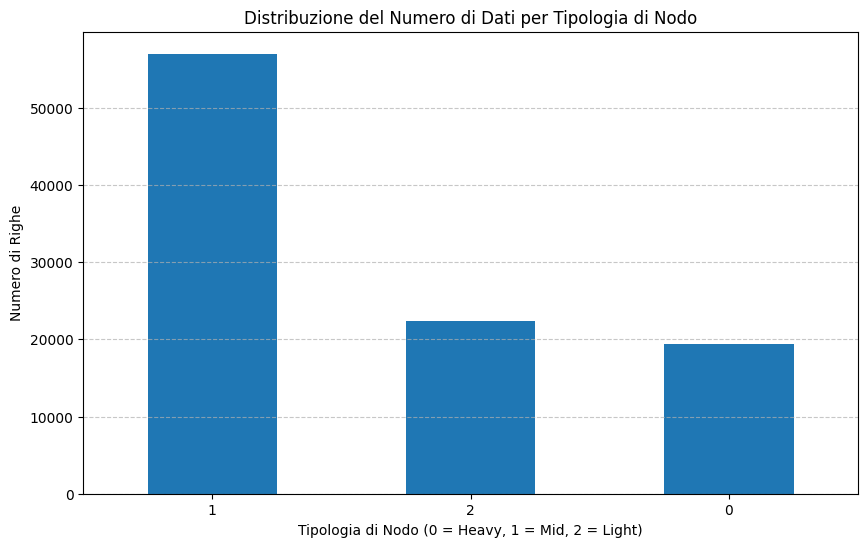

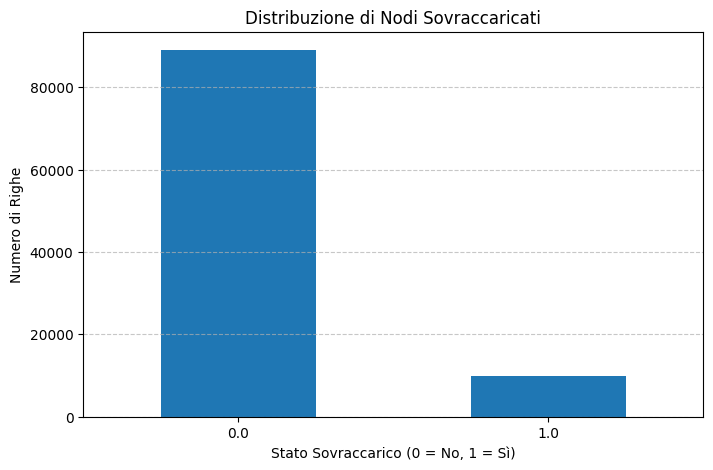

In [24]:
# Plot node type distribution
plot_node_type_distribution(df)
# Plot overloaded node distribution
plot_overloaded_node_distribution(df)

#### Removing outliers

In [25]:
# Iterate over each target column and handle outliers
functions_column = [col for col in df if col.startswith('rate')]
targets = [col for col in df if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]
grouped = df.groupby(functions_column + ['node_type'])
threshold = 1
for target in targets:
    print(target)
    if target != 'overloaded_node':
        mean = grouped[target].transform('mean')
        std = grouped[target].transform('std')
        outliers = (df[target] > mean + threshold * std) | (df[target] < mean - threshold * std)
        print(outliers.sum())
        df[target] = df[target].where(~outliers, mean)
    else:
        new_overloaded = grouped[target].transform('all')
        df['overloaded_node'] = new_overloaded.astype(int)
        print(df["overloaded_node"].value_counts())
df_only_useful = df[functions_column + targets + ["node_type"]]

cpu_usage_function_shasum
23887
ram_usage_function_shasum
23430
power_usage_function_shasum
23895
medium_latency_function_shasum
23610
cpu_usage_function_curl
14017
ram_usage_function_curl
13650
power_usage_function_curl
13997
medium_latency_function_curl
13920
cpu_usage_function_eat-memory
4571
ram_usage_function_eat-memory
4501
power_usage_function_eat-memory
4595
medium_latency_function_eat-memory
4564
cpu_usage_node
32752
ram_usage_node
32400
ram_usage_node_percentage
32140
power_usage_node
32498
overloaded_node
overloaded_node
0    90739
1     8045
Name: count, dtype: int64
cpu_usage_function_nmap
7319
ram_usage_function_nmap
7245
power_usage_function_nmap
7318
medium_latency_function_nmap
7301
cpu_usage_function_env
19397
ram_usage_function_env
18812
power_usage_function_env
19415
medium_latency_function_env
19202
cpu_usage_function_figlet
19900
ram_usage_function_figlet
19762
power_usage_function_figlet
19876
medium_latency_function_figlet
19790


#### Create dataset of groups

In [26]:
# Get the groups definition from the group_list.json 
with open(GROUP_FILE_PATH, 'r') as json_file:
    groups_number = json.load(json_file)

# Map groups number with the correspondent name
groups = {}
for key, value in groups_number.items():
    if "figlet" in value:
        groups["LOW_USAGE"] = value
    elif "nmap" in value:
        groups["HIGH_USAGE"] = value
    else:
        groups["MEDIUM_USAGE"] = value

df_groups = pd.DataFrame()
columns = {}
for key, group in groups.items():
    for metric in FUNCTION_COLUMNS:
        temp_columns = [metric + fun for fun in group]
        col_name = metric.replace('function_', '')

        # Reaname the column name
        if col_name == 'rate_':
            col_name = 'rate_group_'

        # Creates a dataset where the 0 values in the selected columns are replaced with NaN
        df_no_zeros = df[temp_columns].mask(df[temp_columns] == 0)
        if (metric.__contains__('rate') or metric.__contains__('usage') or metric.__contains__('power') or metric.__contains__('replica')) and not metric.__contains__('success'):
            df_groups[col_name + key] = df[temp_columns].sum(axis=1)
        elif metric.__contains__('overloaded'):
            df_groups[col_name + key] = df[temp_columns].any(axis=1).astype(int)
        else:
            df_groups[col_name + key] = df_no_zeros.mean(axis=1)

df_groups = fill_NaN(df_groups)

# Gets all the node columns names present in df
node_metrics = [col for col in df if col.endswith('node') or 'node_type' in col] 

# Copy all the node columns in df_groups 
for metric in node_metrics:
    df_groups[metric] = df[metric]

In [27]:
df_groups

rate_group_HIGH_USAGE  success_rate_HIGH_USAGE  cpu_usage_HIGH_USAGE  \
0                        0.0                   1.0000              0.000000   
1                        0.0                   1.0000              0.000000   
2                        0.0                   1.0000              0.000000   
3                       10.0                   0.5385             21.921667   
4                       10.0                   0.5365             21.635000   
...                      ...                      ...                   ...   
98779                   70.0                   1.0000            301.279000   
98780                   70.0                   0.9880            300.652667   
98781                   70.0                   0.9810            307.569000   
98782                   70.0                   0.9840            316.240667   
98783                   70.0                   0.9755            316.240667   

       ram_usage_HIGH_USAGE  power_usage_HIGH_USAGE  replica_HIGH_USAGE  \
0              0.000000e+00                0.000000                 0.0   
1              0.000000e+00                0.000000                 0.0   
2              0.000000e+00                0.000000                 0.0   
3              8.959594e+07             3764.469000                 1.0   
4              9.420470e+07             3827.055000                 1.0   
...                     ...                     ...                 ...   
98779          2.022266e+08            36485.712000                 3.0   
98780          3.036606e+08            38699.225000                 3.0   
98781          2.909239e+08            42096.541000                 3.0   
98782          2.953576e+08            43094.165833                 3.0   
98783          3.123070e+08            44487.116000                 3.0   

       overloaded_HIGH_USAGE  medium_latency_HIGH_USAGE  rate_group_LOW_USAGE  \
0                          0               0.000000e+00                 100.0   
1                          0               0.000000e+00                 100.0   
2                          0               0.000000e+00                 100.0   
3                          1               1.436266e+10                 100.0   
4                          1               1.472931e+10                 100.0   
...                      ...                        ...                   ...   
98779                      0               1.655140e+10                  90.0   
98780                      0               1.697898e+10                  90.0   
98781                      0               1.728170e+10                 100.0   
98782                      0               1.793603e+10                 100.0   
98783                      0               1.753096e+10                 100.0   

       success_rate_LOW_USAGE  ...  overloaded_MEDIUM_USAGE  \
0                         1.0  ...                        0   
1                         1.0  ...                        0   
2                         1.0  ...                        0   
3                         1.0  ...                        0   
4                         1.0  ...                        0   
...                       ...  ...                      ...   
98779                     1.0  ...                        0   
98780                     1.0  ...                        0   
98781                     1.0  ...                        0   
98782                     1.0  ...                        0   
98783                     1.0  ...                        0   

       medium_latency_MEDIUM_USAGE  cpu_usage_idle_node  cpu_usage_node  \
0                     9.586719e+08               59.000      124.895875   
1                     6.293711e+08               64.933      127.617000   
2                     1.048772e+09               61.667      121.317000   
3                     1.016027e+10               72.133      145.871333   
4                     1.099271e+10               62.

In [30]:
df_groups.columns

Index(['rate_group_HIGH_USAGE', 'success_rate_HIGH_USAGE',
       'cpu_usage_HIGH_USAGE', 'ram_usage_HIGH_USAGE',
       'power_usage_HIGH_USAGE', 'replica_HIGH_USAGE', 'overloaded_HIGH_USAGE',
       'medium_latency_HIGH_USAGE', 'rate_group_LOW_USAGE',
       'success_rate_LOW_USAGE', 'cpu_usage_LOW_USAGE', 'ram_usage_LOW_USAGE',
       'power_usage_LOW_USAGE', 'replica_LOW_USAGE', 'overloaded_LOW_USAGE',
       'medium_latency_LOW_USAGE', 'rate_group_MEDIUM_USAGE',
       'success_rate_MEDIUM_USAGE', 'cpu_usage_MEDIUM_USAGE',
       'ram_usage_MEDIUM_USAGE', 'power_usage_MEDIUM_USAGE',
       'replica_MEDIUM_USAGE', 'overloaded_MEDIUM_USAGE',
       'medium_latency_MEDIUM_USAGE', 'cpu_usage_idle_node', 'cpu_usage_node',
       'ram_usage_idle_node', 'ram_usage_node', 'power_usage_idle_node',
       'power_usage_node', 'overloaded_node', 'node_type'],
      dtype='object')

In [29]:
df_groups.to_csv(os.path.join(PATH_TO_CVS, "grouped_results_no_outliers.csv"), index = False)

#### Partitioning into features and targets and oversampling

In [31]:
# Dataframe division by features and output
targets = [col for col in df_groups if (col.startswith('power_usage_') or col.startswith('cpu_usage_') or col.startswith('ram_usage_') or col.startswith('overloaded_node') or col.startswith('medium_latency')) and 'idle' not in col]# or col.startswith('replica')
params = [col for col in df_groups if col.startswith('rate_') or 'node_type' in col]

# Initialize a dictionary to store target datasets
target_datasets = {}
features_datasets = {}
features_datasets['original'] = df_groups[params]
for target_name in targets:
    X = df_groups[params]
    y = df_groups[[target_name]]
    node_type_index = X.columns.get_loc("node_type")

    if "overloaded" in target_name:
        print("Status of target: " + target_name)
        print(y.value_counts())
        # Oversampling
        sm = SMOTENC(random_state=42, categorical_features=[node_type_index])
        try:
            X_res, y_res = sm.fit_resample(X, y)
            result_df = pd.concat([X_res, y_res], axis=1)
            print("Status after SMOTE:")
            print(y_res.value_counts())
            print(X_res["node_type"].value_counts())
            features_datasets[target_name] = X_res
            y = y_res
        except:
            print("It was not possible to perform SMOTE for target " + target_name)

    target_datasets[target_name] = y

Status of target: overloaded_node
overloaded_node
0                  90739
1                   8045
Name: count, dtype: int64
Status after SMOTE:
overloaded_node
0                  90739
1                  90739
Name: count, dtype: int64
node_type
1    84261
2    65801
0    31416
Name: count, dtype: int64


#### Preprocessing

In [32]:
# Initialize dictionaries to store scaled data and train-test splits
x_train_dict = {}
x_test_dict = {}
y_train_dict = {}
y_test_dict = {}
y_scalers = {}
scaler_exist = False

for target_name in targets:
    # Get the target dataset for the current iteration
    target_dataset = target_datasets[target_name]

    # Apply scaling for x (features)
    if "overloaded" in target_name:
        X = features_datasets[target_name]
    else:
        X = features_datasets['original']
    scaler_x = MinMaxScaler()
    scaler_x.fit(X)
    X_scaled = scaler_x.transform(X)

    # Apply scaling for y (target)
    scaler_y = MinMaxScaler()
    scaler_y.fit(target_dataset)
    y_scalers[target_name] = scaler_y
    if target_name.startswith('overloaded') or target_name.startswith('replica'):
        y_scaled = target_dataset
    else:
        y_scaled = scaler_y.transform(target_dataset)

    # Save the scaler for x
    scaler_x_path = './scalers/groups/scaler_x/' 
    if not os.path.exists(scaler_x_path):
        os.makedirs(scaler_x_path)
    if target_name.startswith('overloaded'):
        joblib.dump(scaler_x, scaler_x_path + "/" + target_name + ".joblib")
    elif not scaler_exist:
        scaler_exist = True
        joblib.dump(scaler_x, scaler_x_path + "/features.joblib")

    # Save the scaler for y
    scaler_y_path = './scalers/groups/scaler_y/'
    if not os.path.exists(scaler_y_path):
        os.makedirs(scaler_y_path)
    if not target_name.startswith("overloaded"):
        joblib.dump(scaler_y, scaler_y_path + "/" + target_name + ".joblib")

    # Split the dataset into training and testing
    x_train, x_test, y_train, y_test = train_test_split(X_scaled, y_scaled)
    x_train_dict[target_name] = x_train
    x_test_dict[target_name] = x_test
    y_train_dict[target_name] = y_train
    y_test_dict[target_name] = y_test

#### Train models

In [33]:
#One Model for each target variable
#Initialize a dictionary to store models
trained_models = {}
for target_name in targets:
    #Get the corresponding x_train for the current target
    x_train = x_train_dict[target_name]

    # Get the corresponding y_train for the current target
    y_train = y_train_dict[target_name]

    #Trains the specific model for the current target
    model = train_model(target_name, x_train, y_train, 0)  # Use the specific target's y_train
    trained_models[target_name] = model
    if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
        for quantile in QUANTILES:
            model = train_model(target_name, x_train, y_train, quantile)
            trained_models[target_name + " " + str(quantile)] = model

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 74088, number of used features: 4
[LightGBM] [Info] Start training from score 0.108605
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 92
[LightGBM] [Info] Number of data points in the train set: 74088, number of used features: 4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

#### Predict

In [34]:
# Initialize dictionary to store predictions
all_predictions = {}  
for target_name in targets:

    # Get the corresponding x_train for the current target
    x_test = x_test_dict[target_name]

    # Get the test dataset for the current iteration
    y_test = y_test_dict[target_name]

    # Train model
    test_data = pd.DataFrame(np.column_stack((x_test, y_test)), columns=[*params, target_name])

    model = trained_models[target_name]
    y_pred = model.predict(test_data.drop(columns=[target_name]))
    all_predictions[target_name] = y_pred
    if not(target_name.startswith('overloaded') or target_name.startswith('replica')):
        y_pred_quantiles = {}
        for quantile in QUANTILES:
            model = trained_models[target_name + " " + str(quantile)]
            y_pred_quantiles[str(quantile)] = model.predict(test_data.drop(columns=[target_name]))
        all_predictions[target_name + " quantiles"] = y_pred_quantiles

#### Plot results

Target: cpu_usage_HIGH_USAGE
mape: 164032577718.2837
mse: 0.0004242954529469646
rmse: 0.020598433264376312
R-squared score: 0.987835264595349
Standard deviation: 0.18595652861107073


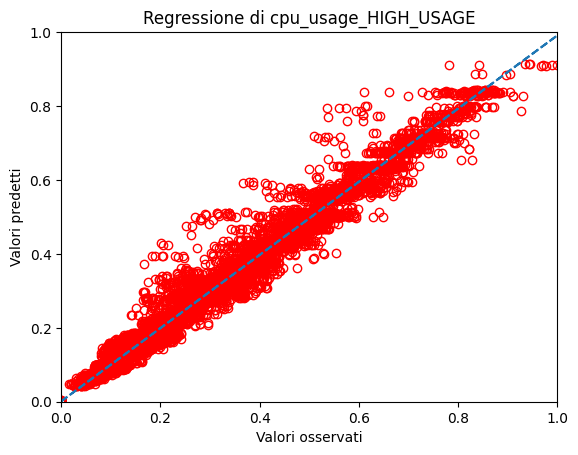

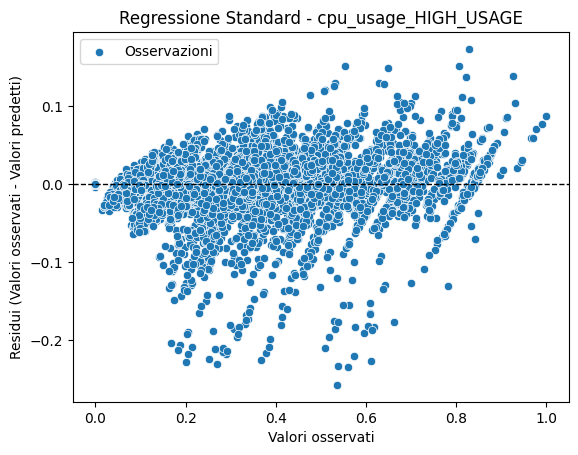

mape: 60502596128487.2
mse: 57.72396820554732
rmse: 7.597629117398882
R-squared score: 0.987835264595349
Standard deviation: 68.58913579555039
Quantile loss with library:  1.489173544837867
------------------------------
Target: cpu_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 2.1825396825396823 % of cases and less or equal in 97.81746031746032 % of cases.
mape: 0.06468838968345424
mse: 0.0022417041197717496
rmse: 0.04734663789300936
R-squared score: 0.9357293666874436
Standard deviation: 0.15400650512922273
Quantile loss with library:  0.0012314773064168174
Prediction for alpha 0.95 are greater than true values in 97.50971817298348 % of cases and less or equal in 2.490281827016521 % of cases.
mape: 23584240847553.938
mse: 0.0011508677113151624
rmse: 0.03392444120859123
R-squared score: 0.9670041215462774
Standard deviation: 0.20140249366937735
Quantile loss with library:  0.001084995651160485


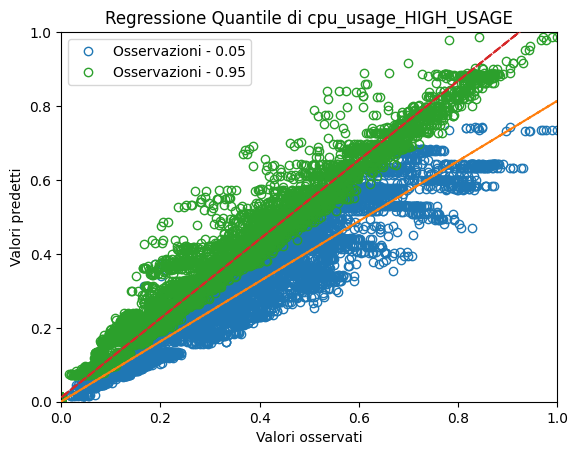

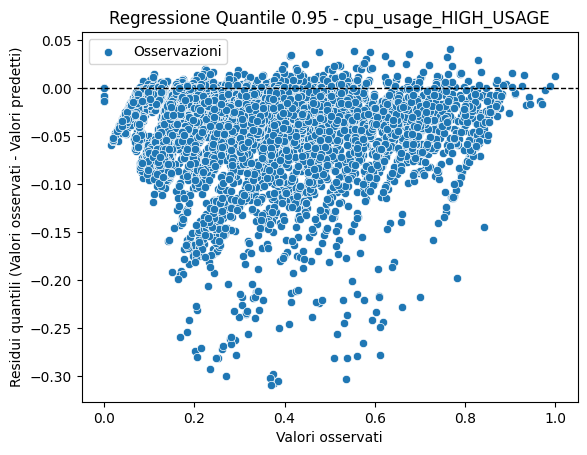

mape: 8698929315416006.0
mse: 156.57167833248326
rmse: 12.51286051758283
R-squared score: 0.9670041215462774
Standard deviation: 74.28630277748147
Quantile loss with library:  0.4001952209522891
------------------------------
Target: ram_usage_HIGH_USAGE
mape: 271663664448.88922
mse: 0.007770659433692092
rmse: 0.08815134391313664
R-squared score: 0.6222849242098214
Standard deviation: 0.11153997699263488


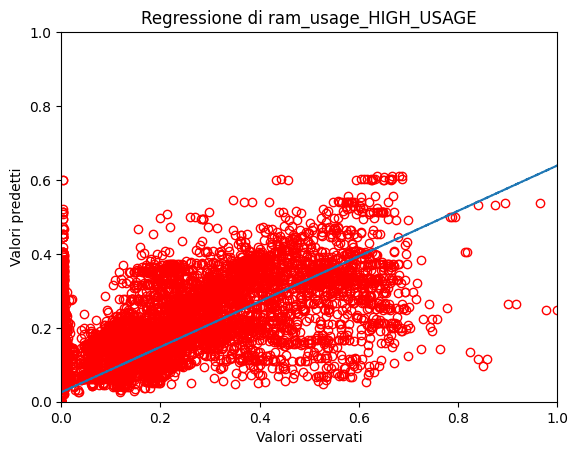

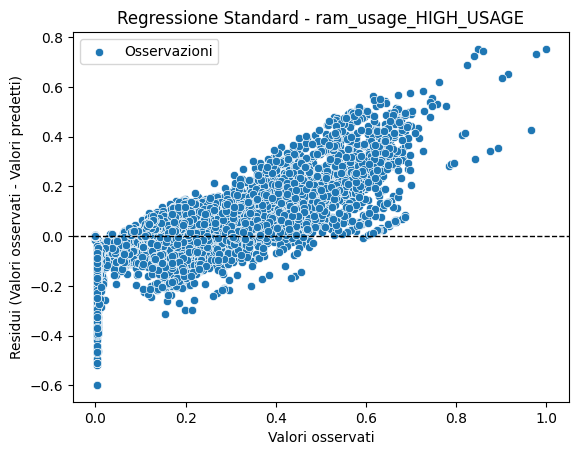

mape: 1.219955969772622e+20
mse: 1567050814390326.8
rmse: 39585992.65384571
R-squared score: 0.6222849242098213
Standard deviation: 50089091.258682005
Quantile loss with library:  8948011.576452961
------------------------------
Target: ram_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 2.1987366375121478 % of cases and less or equal in 97.80126336248786 % of cases.
mape: 0.2664828924761792
mse: 0.020464550173263773
rmse: 0.14305436090264348
R-squared score: 0.005262142078774068
Standard deviation: 0.037626788627187276
Quantile loss with library:  0.0030740254746915246
Prediction for alpha 0.95 are greater than true values in 97.9389374797538 % of cases and less or equal in 2.061062520246194 % of cases.
mape: 31559217706.04229
mse: 0.029308073675554942
rmse: 0.17119600951995037
R-squared score: -0.42460255324387686
Standard deviation: 0.21635304297372324
Quantile loss with library:  0.0042136624412312754


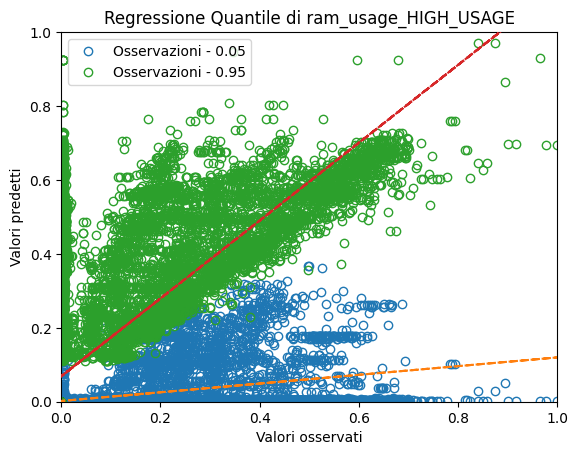

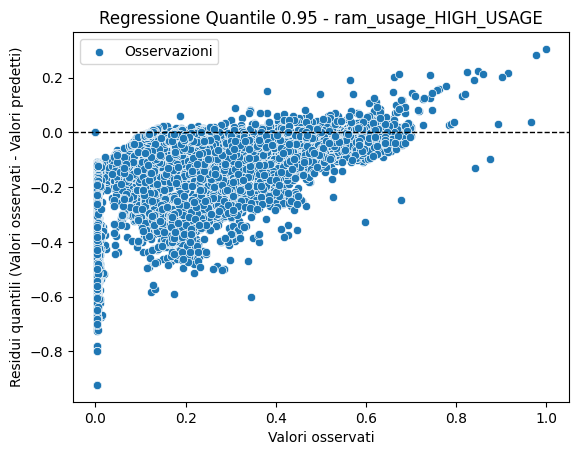

mape: 1.417225086233124e+19
mse: 5910340185848106.0
rmse: 76878736.89030086
R-squared score: -0.4246025532438771
Standard deviation: 97157338.61340092
Quantile loss with library:  1892223.113566274
------------------------------
Target: power_usage_HIGH_USAGE
mape: 134083885124.36163
mse: 0.00040506179523856994
rmse: 0.02012614705398353
R-squared score: 0.9823595475953286
Standard deviation: 0.1500706148032059


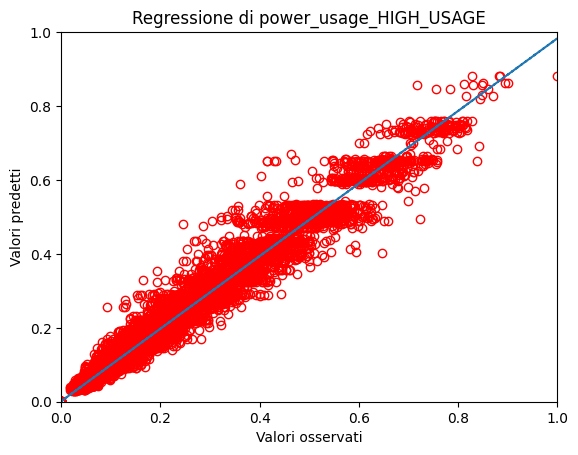

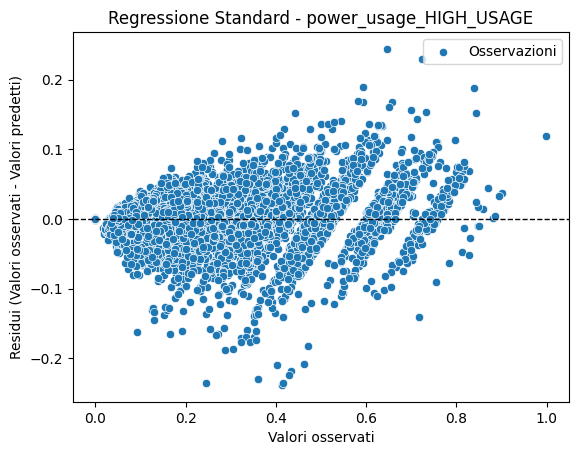

mape: 7888394033430777.0
mse: 1401991.254201372
rmse: 1184.0571161060484
R-squared score: 0.9823595475953286
Standard deviation: 8828.921844778799
Quantile loss with library:  235.4467515997292
------------------------------
Target: power_usage_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 1.830255911888565 % of cases and less or equal in 98.16974408811143 % of cases.
mape: 0.08074703028863452
mse: 0.0017939339963975586
rmse: 0.04235485800233025
R-squared score: 0.9218741247568547
Standard deviation: 0.1212554235288547
Quantile loss with library:  0.0010721849790161686
Prediction for alpha 0.95 are greater than true values in 97.2181729834791 % of cases and less or equal in 2.781827016520894 % of cases.
mape: 1088868352226.6359
mse: 0.0014013119288285635
rmse: 0.03743410114893322
R-squared score: 0.9389728266768796
Standard deviation: 0.17446382868395358
Quantile loss with library:  0.0010201585260834136


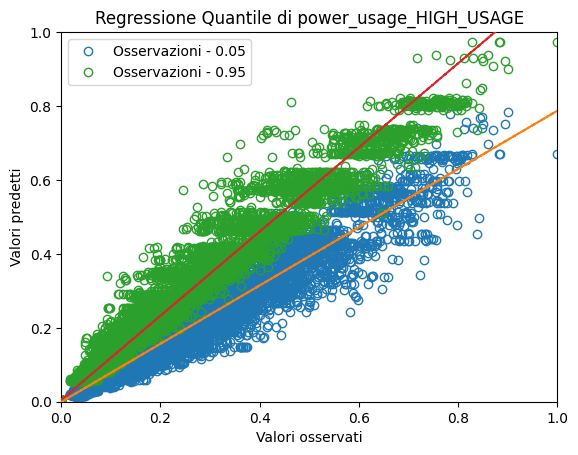

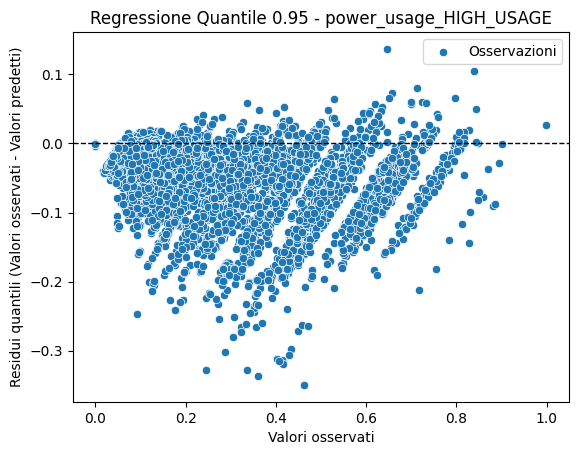

mape: 6.4060066613759176e+16
mse: 4850190.987448203
rmse: 2202.31491559409
R-squared score: 0.9389728266768796
Standard deviation: 10264.018110483532
Quantile loss with library:  60.017745032139246
------------------------------
Target: medium_latency_HIGH_USAGE
mape: 507849410118.3199
mse: 0.002270506262695219
rmse: 0.047649829618742805
R-squared score: 0.9422767359180839
Standard deviation: 0.1919135275878675


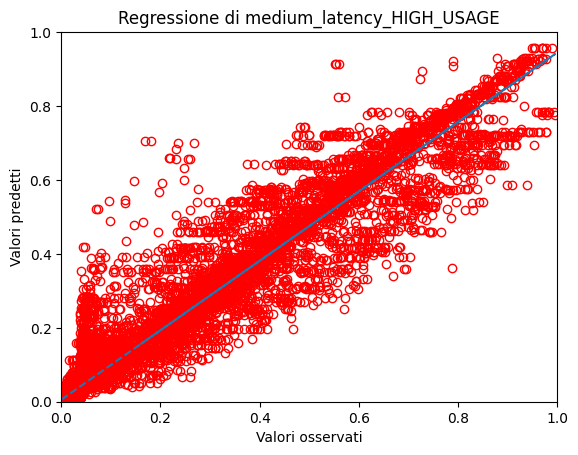

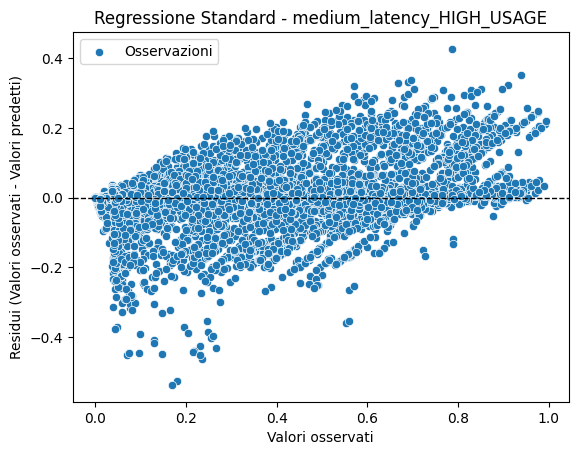

mape: 1.501448812044484e+22
mse: 1.9846039928096955e+18
rmse: 1408759735.6574667
R-squared score: 0.9422767359180839
Standard deviation: 5673893328.832208
Quantile loss with library:  253264435.7106827
------------------------------
Target: medium_latency_HIGH_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 1.8019112406867508 % of cases and less or equal in 98.19808875931325 % of cases.
mape: 0.160115335625684
mse: 0.01689712319229381
rmse: 0.12998893488406546
R-squared score: 0.5704230724756335
Standard deviation: 0.10659686905478528
Quantile loss with library:  0.0025732061207643397
Prediction for alpha 0.95 are greater than true values in 98.28717201166181 % of cases and less or equal in 1.7128279883381923 % of cases.
mape: 46784012274.31972
mse: 0.008435459688370428
rmse: 0.09184475863308927
R-squared score: 0.7855446270973243
Standard deviation: 0.23874622140682553
Quantile loss with library:  0.002154587059854812


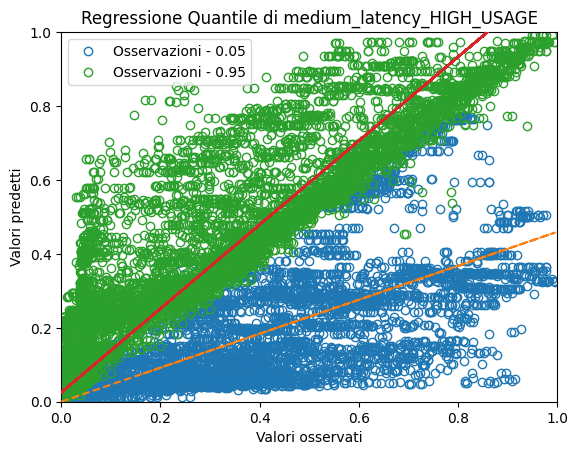

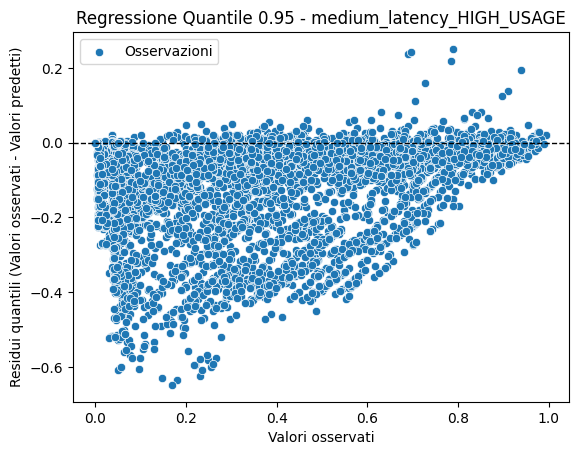

mape: 1.3831619817051421e+21
mse: 7.373266153801578e+18
rmse: 2715375877.0751386
R-squared score: 0.7855446270973243
Standard deviation: 7058494572.790718
Quantile loss with library:  63700028.33542442
------------------------------
Target: cpu_usage_LOW_USAGE
mape: 183380163055.1862
mse: 0.0009337864847884416
rmse: 0.03055792016463885
R-squared score: 0.9755982180646103
Standard deviation: 0.19341318960676543


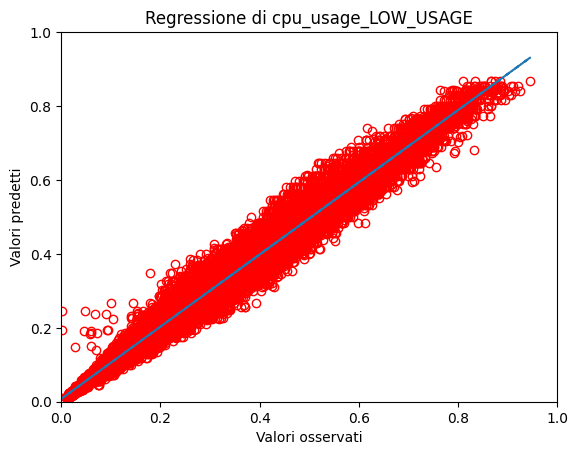

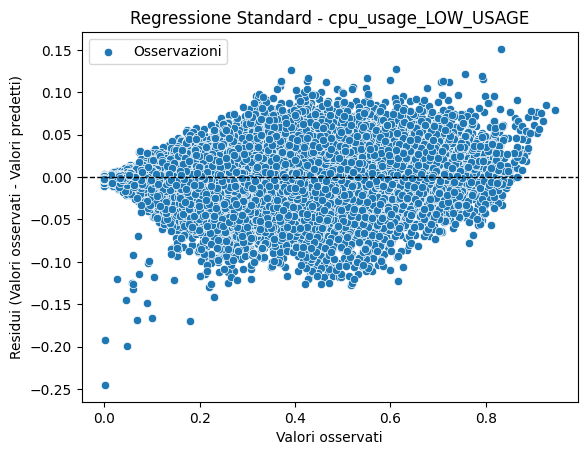

mape: 11995507732643.914
mse: 3.9955828909136892
rmse: 1.9988954177029095
R-squared score: 0.9755982180646103
Standard deviation: 12.651801442810552
Quantile loss with library:  0.6911828599349495
------------------------------
Target: cpu_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 8.414318108195658 % of cases and less or equal in 91.58568189180434 % of cases.
mape: 95733276.82290927
mse: 0.0038855454748808246
rmse: 0.062334143732635204
R-squared score: 0.8984626197502064
Standard deviation: 0.16720315269973804
Quantile loss with library:  0.0026776504901822986
Prediction for alpha 0.95 are greater than true values in 95.75639779721412 % of cases and less or equal in 4.243602202785876 % of cases.
mape: 8021237499241.295
mse: 0.0034825180058912194
rmse: 0.059012863054517355
R-squared score: 0.9089945652992839
Standard deviation: 0.20505798885165127
Quantile loss with library:  0.0027051010946072297


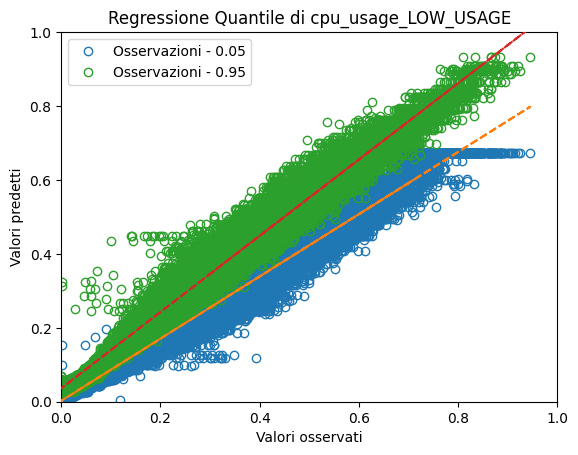

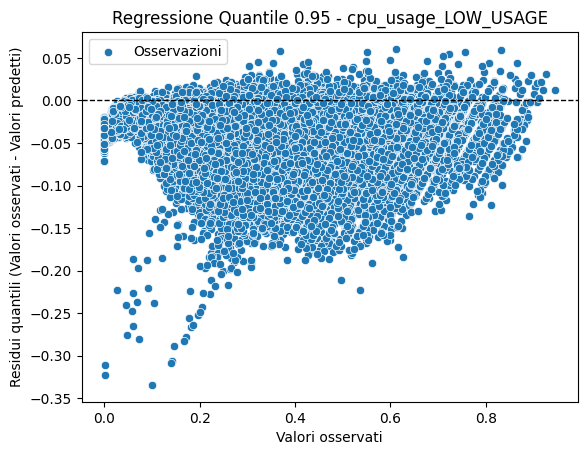

mape: 524695882283688.44
mse: 14.90136084459428
rmse: 3.860228081939496
R-squared score: 0.9089945652992839
Standard deviation: 13.413526577416016
Quantile loss with library:  0.17694967960190758
------------------------------
Target: ram_usage_LOW_USAGE
mape: 259422399229.926
mse: 0.0071677588739363345
rmse: 0.08466261792512876
R-squared score: 0.5606441498090261
Standard deviation: 0.09498147203349995


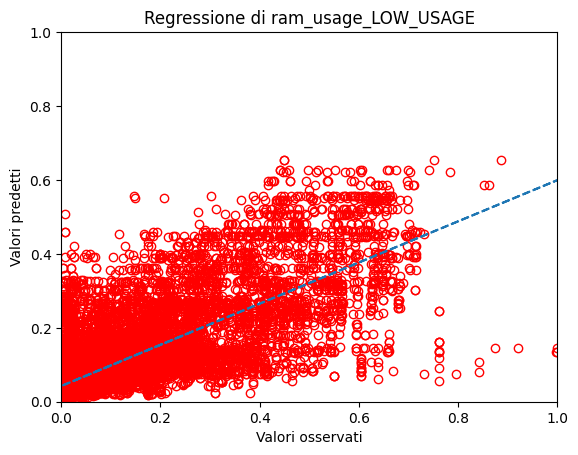

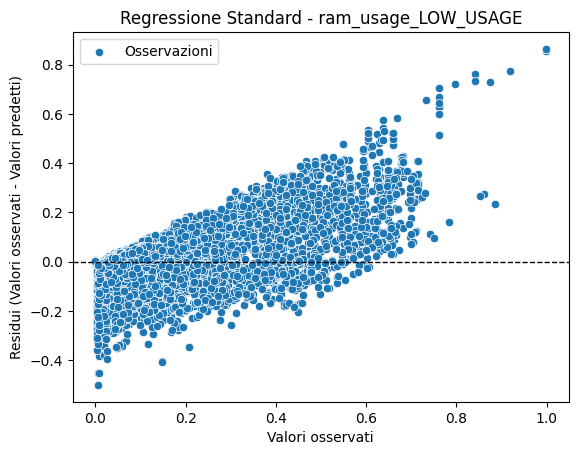

mape: 1.0331067464208676e+20
mse: 1136733971666252.5
rmse: 33715485.635924816
R-squared score: 0.560644149809026
Standard deviation: 37824798.41169631
Quantile loss with library:  10354486.012532039
------------------------------
Target: ram_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 8.00939423388403 % of cases and less or equal in 91.99060576611598 % of cases.
mape: 14325491.374609107
mse: 0.01842433023958948
rmse: 0.13573625248838087
R-squared score: -0.12934006556063804
Standard deviation: 0.044579533928769545
Quantile loss with library:  0.004198277213325748
Prediction for alpha 0.95 are greater than true values in 95.229996760609 % of cases and less or equal in 4.770003239390994 % of cases.
mape: 2903543285536.7866
mse: 0.030522326021399017
rmse: 0.17470639948610645
R-squared score: -0.870900337858793
Standard deviation: 0.16906410189837748
Quantile loss with library:  0.0090445607179456


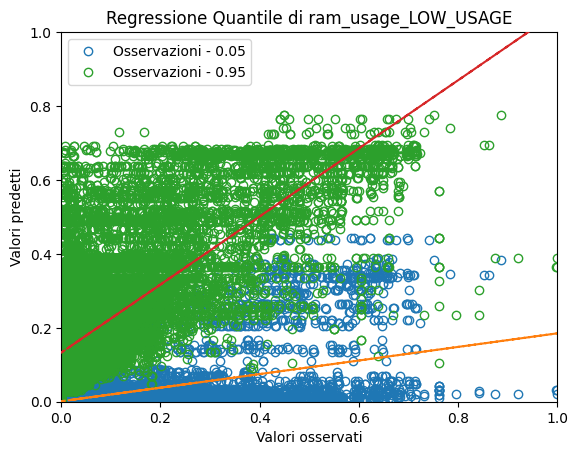

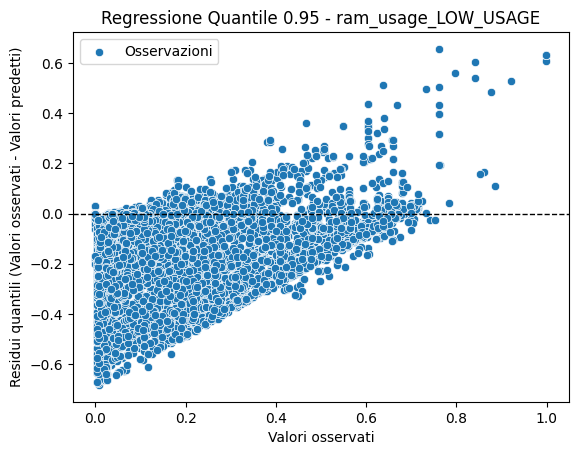

mape: 1.1562880328504168e+21
mse: 4840531816570882.0
rmse: 69573930.58158265
R-squared score: -0.8709003378587932
Standard deviation: 67326978.99970599
Quantile loss with library:  3601846.534427029
------------------------------
Target: power_usage_LOW_USAGE
mape: 181153887047.0509
mse: 0.0018063894235915067
rmse: 0.0425016402458953
R-squared score: 0.9399642548530471
Standard deviation: 0.16807980773196973


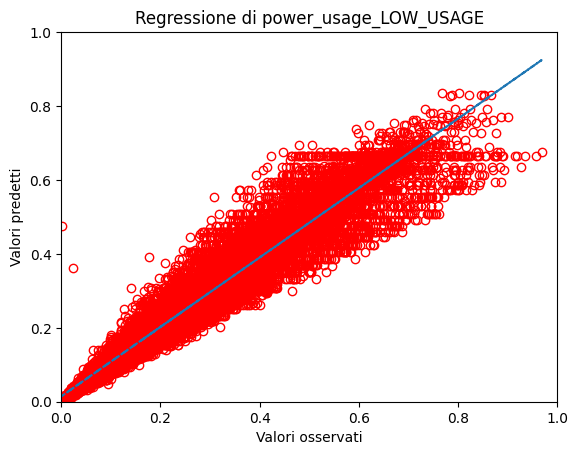

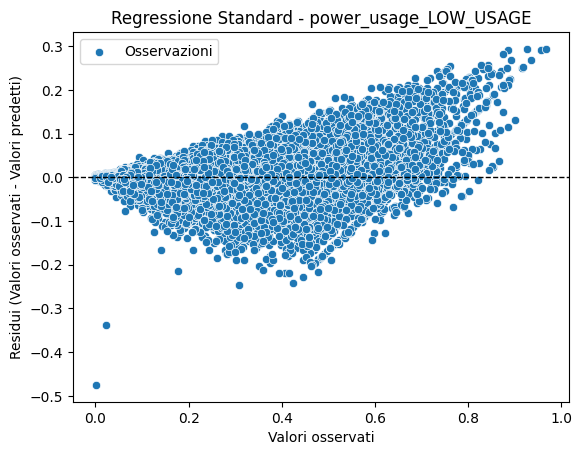

mape: 2.7785646411853616e+16
mse: 42496882.97348769
rmse: 6518.963335798698
R-squared score: 0.9399642548530471
Standard deviation: 25780.325129890152
Quantile loss with library:  2034.0406222480422
------------------------------
Target: power_usage_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 8.624878522837706 % of cases and less or equal in 91.3751214771623 % of cases.
mape: 62168663.301656015
mse: 0.006324101179230741
rmse: 0.0795242175644045
R-squared score: 0.7898171226418236
Standard deviation: 0.1303733656452302
Quantile loss with library:  0.0033048113821026914
Prediction for alpha 0.95 are greater than true values in 95.26239067055393 % of cases and less or equal in 4.737609329446064 % of cases.
mape: 4305746121170.5405
mse: 0.008126274198680509
rmse: 0.09014584959209442
R-squared score: 0.7299215106030389
Standard deviation: 0.2110617455049488
Quantile loss with library:  0.0038017696256772457


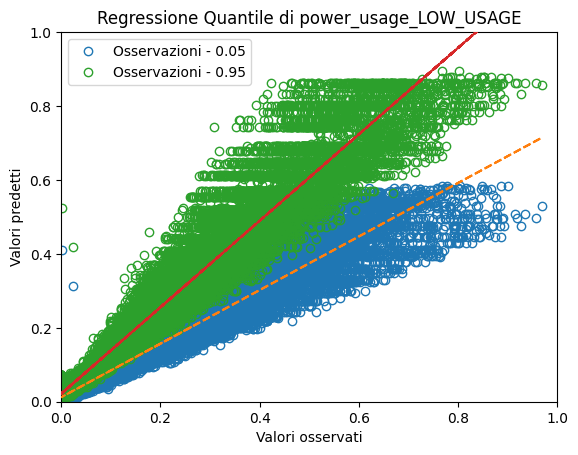

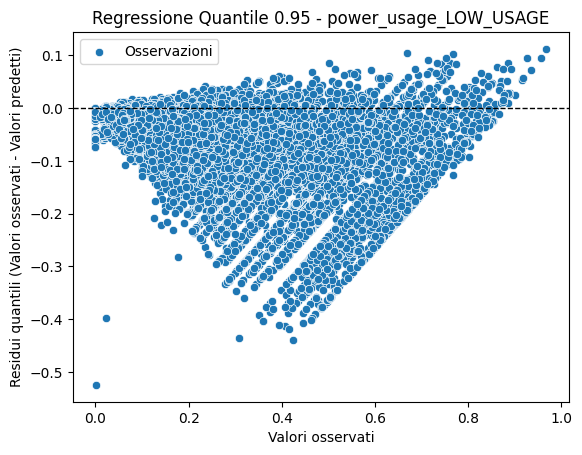

mape: 6.604215963142017e+17
mse: 191177671.3933489
rmse: 13826.701392354898
R-squared score: 0.7299215106030389
Standard deviation: 32372.957198265267
Quantile loss with library:  583.1209491576421
------------------------------
Target: medium_latency_LOW_USAGE
mape: 39695809372.48547
mse: 0.0004960891541390734
rmse: 0.02227305893089392
R-squared score: 0.748536479146787
Standard deviation: 0.036152415954974426


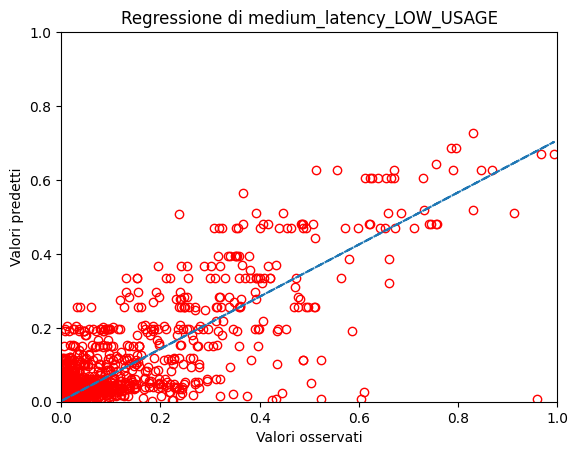

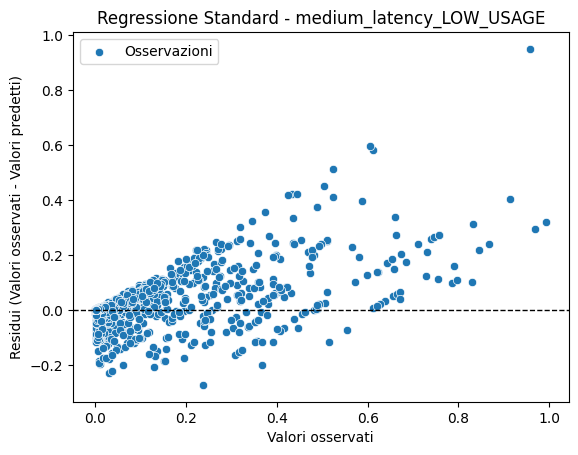

mape: 7.575203108290205e+20
mse: 1.8065873839473453e+17
rmse: 425039690.3757748
R-squared score: 0.748536479146787
Standard deviation: 689901271.8241768
Quantile loss with library:  45449086.39706705
------------------------------
Target: medium_latency_LOW_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 8.928571428571429 % of cases and less or equal in 91.07142857142857 % of cases.
mape: 1368293.972885031
mse: 0.001766705209473402
rmse: 0.04203219253707094
R-squared score: 0.10447162858281145
Standard deviation: 0.0047577118119808744
Quantile loss with library:  0.00033012070231819263
Prediction for alpha 0.95 are greater than true values in 95.01133786848072 % of cases and less or equal in 4.988662131519274 % of cases.
mape: 51965584268.27865
mse: 0.0014838624222096978
rmse: 0.038520934856382937
R-squared score: 0.2478423161696004
Standard deviation: 0.06148425692747973
Quantile loss with library:  0.0011406273060655043


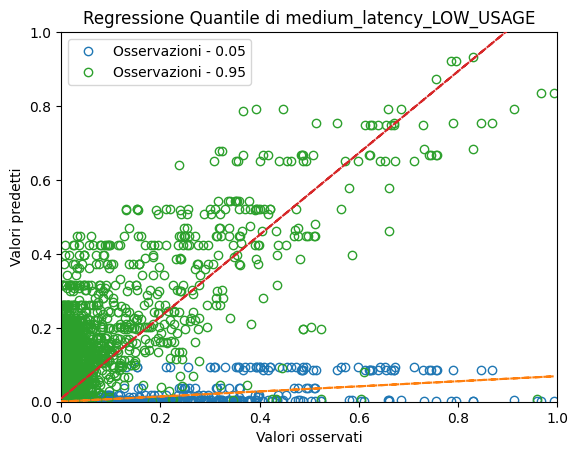

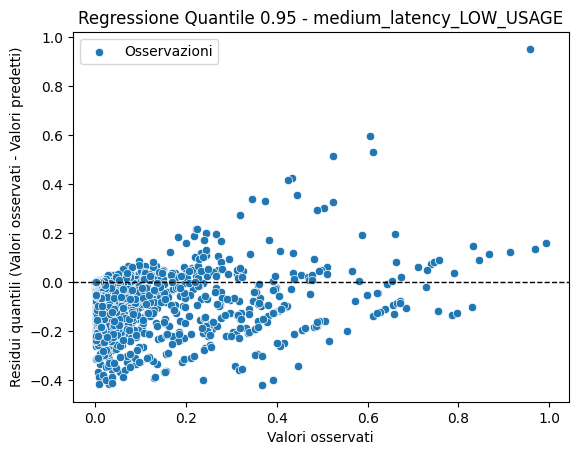

mape: 9.91666026411794e+20
mse: 5.403720498848229e+17
rmse: 735100027.128841
R-squared score: 0.2478423161696004
Standard deviation: 1173312099.0935092
Quantile loss with library:  21766739.74187606
------------------------------
Target: cpu_usage_MEDIUM_USAGE
mape: 192761451303.09747
mse: 0.00022215206074034007
rmse: 0.014904766376576993
R-squared score: 0.9945833461110253
Standard deviation: 0.20162708030417684


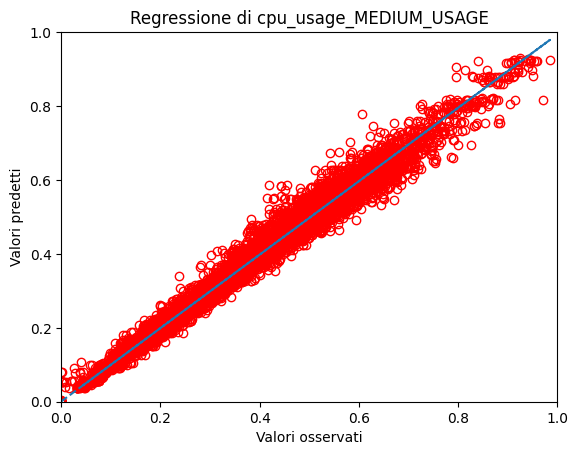

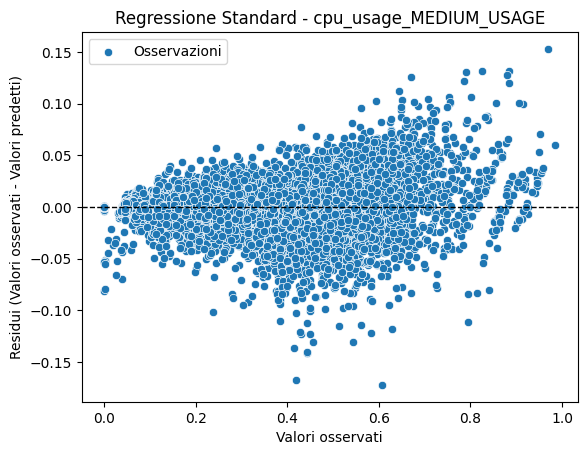

mape: 24930224019926.07
mse: 3.715885586183516
rmse: 1.9276632450154556
R-squared score: 0.9945833461110253
Standard deviation: 26.076833549899803
Quantile loss with library:  0.43472747299555015
------------------------------
Target: cpu_usage_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 1.9193391642371234 % of cases and less or equal in 98.08066083576288 % of cases.
mape: 0.05794491766793363
mse: 0.002175079463390677
rmse: 0.04663774719463491
R-squared score: 0.9469658188407494
Standard deviation: 0.169275007105829
Quantile loss with library:  0.001095470902095615
Prediction for alpha 0.95 are greater than true values in 97.54616132167152 % of cases and less or equal in 2.453838678328474 % of cases.
mape: 667333988372.6346
mse: 0.000879560151261545
rmse: 0.029657379372789245
R-squared score: 0.9785540008134939
Standard deviation: 0.22090026684995828
Quantile loss with library:  0.0008591220918251245


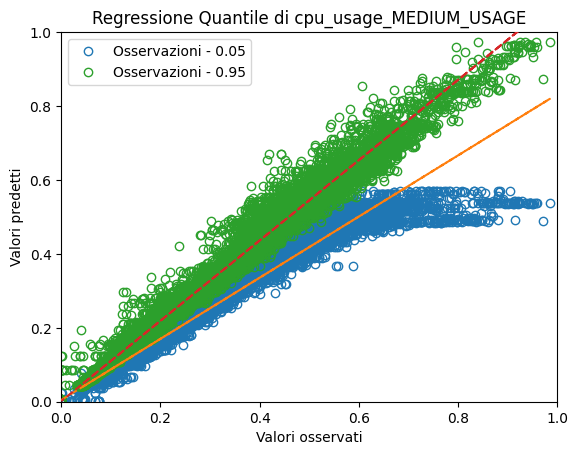

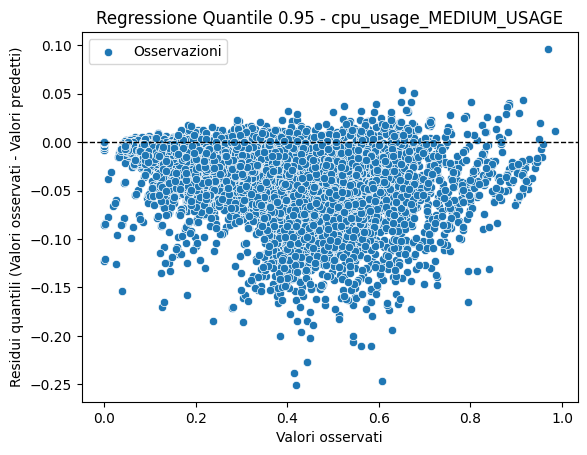

mape: 86307639384198.39
mse: 14.712197030097938
rmse: 3.8356481890415783
R-squared score: 0.9785540008134939
Standard deviation: 28.569473312238802
Quantile loss with library:  0.11111197837992699
------------------------------
Target: ram_usage_MEDIUM_USAGE
mape: 736773377569.8157
mse: 0.023077638700753272
rmse: 0.15191326045067058
R-squared score: 0.5273836743605833
Standard deviation: 0.16218634047976282


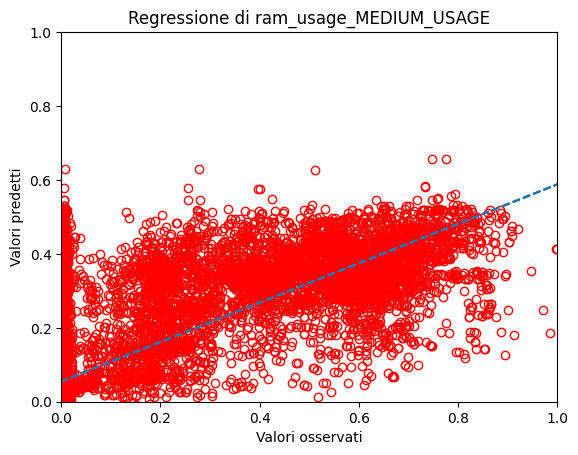

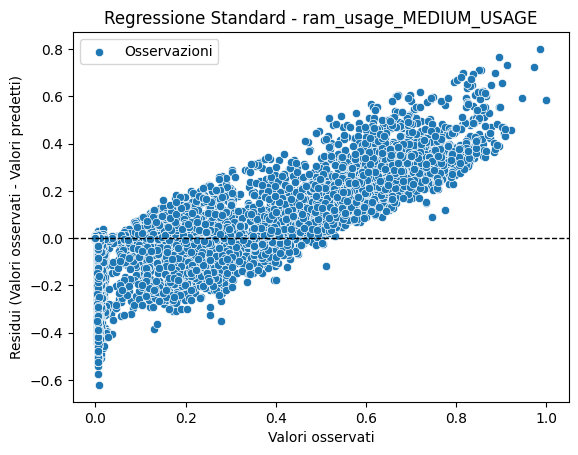

mape: 2.1332168374611205e+20
mse: 1934610435790464.5
rmse: 43984206.66319292
R-squared score: 0.5273836743605835
Standard deviation: 46958622.94342172
Quantile loss with library:  11505612.823013293
------------------------------
Target: ram_usage_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 2.2513767411726593 % of cases and less or equal in 97.74862325882734 % of cases.
mape: 0.26716777094579947
mse: 0.05994406888829507
rmse: 0.24483477875558257
R-squared score: -0.2276189063024614
Standard deviation: 0.00979603960094806
Quantile loss with library:  0.00557756248959068
Prediction for alpha 0.95 are greater than true values in 97.77696793002916 % of cases and less or equal in 2.2230320699708455 % of cases.
mape: 43263157024.684906
mse: 0.0690379652447084
rmse: 0.26275076640175266
R-squared score: -0.4138564992141427
Standard deviation: 0.3116205800739974
Quantile loss with library:  0.007480737312413431


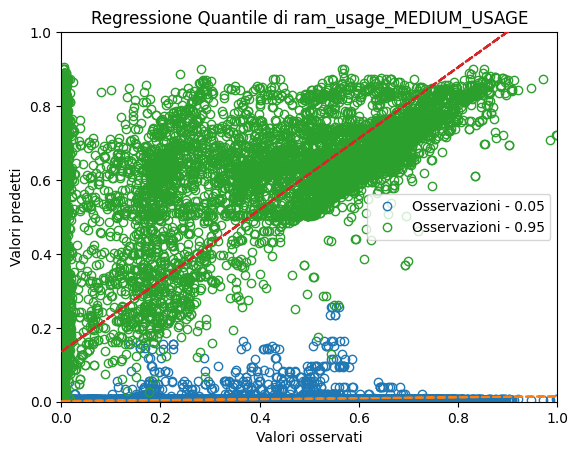

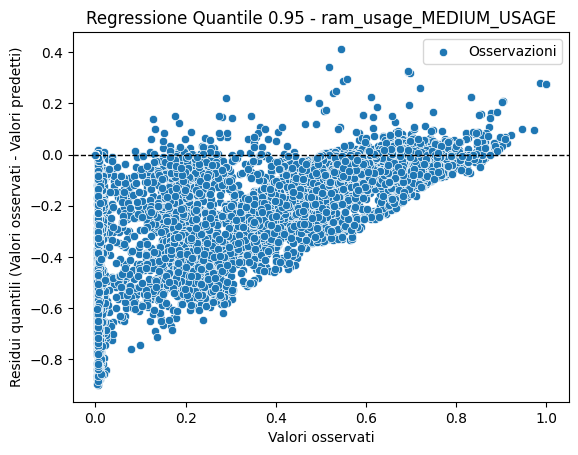

mape: 1.2526198392010013e+19
mse: 5787488475750888.0
rmse: 76075544.53141224
R-squared score: -0.41385649921414225
Standard deviation: 90225066.28991425
Quantile loss with library:  2165935.317075859
------------------------------
Target: power_usage_MEDIUM_USAGE
mape: 137419041855.86688
mse: 0.0005583072725971799
rmse: 0.02362852667004822
R-squared score: 0.9766949798352087
Standard deviation: 0.1527690646465377


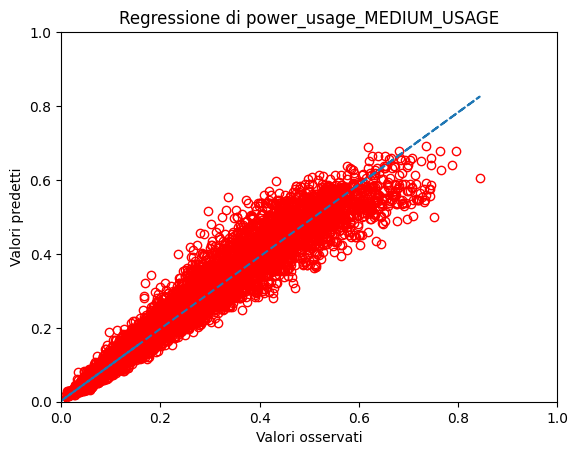

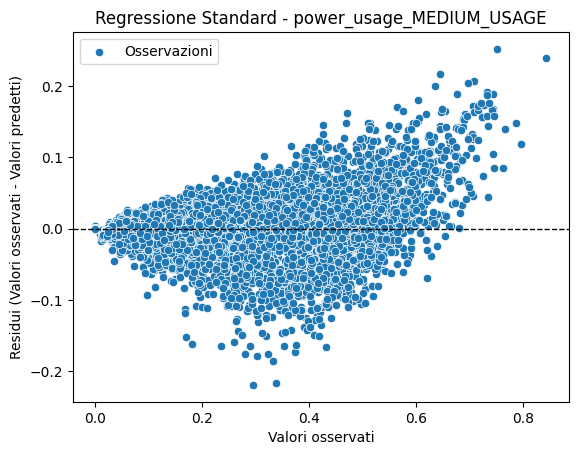

mape: 1.7810383870906056e+16
mse: 9378340.849333044
rmse: 3062.40768829577
R-squared score: 0.9766949798352088
Standard deviation: 19799.844680978404
Quantile loss with library:  649.2113010289589
------------------------------
Target: power_usage_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 2.239229024943311 % of cases and less or equal in 97.76077097505669 % of cases.
mape: 0.08546040217561832
mse: 0.002159926426434798
rmse: 0.04647500862221327
R-squared score: 0.9098397398830825
Standard deviation: 0.12017819552792541
Quantile loss with library:  0.001274037720827594
Prediction for alpha 0.95 are greater than true values in 97.62714609653386 % of cases and less or equal in 2.3728539034661487 % of cases.
mape: 132948203072.54974
mse: 0.0021099363566227324
rmse: 0.04593404354749027
R-squared score: 0.911926439523569
Standard deviation: 0.18468016942398327
Quantile loss with library:  0.0014268925144430278


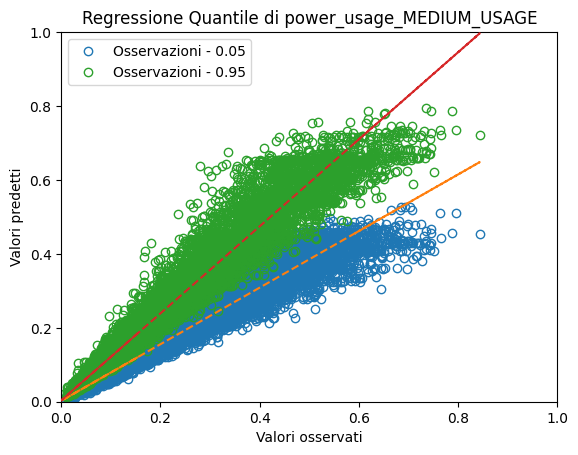

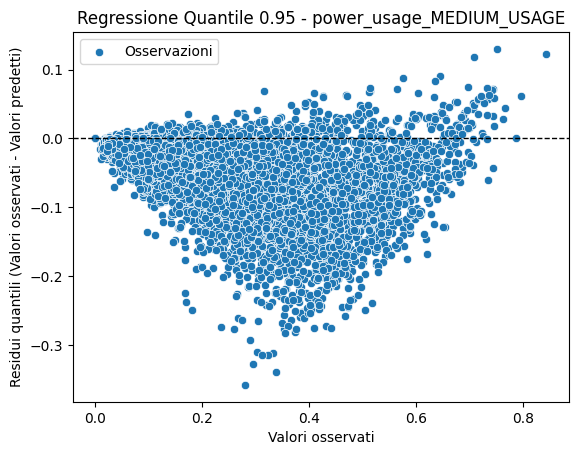

mape: 1.7230934662982984e+16
mse: 35442315.18023729
rmse: 5953.3448732823545
R-squared score: 0.911926439523569
Standard deviation: 23935.727293428306
Quantile loss with library:  184.9343663115959
------------------------------
Target: medium_latency_MEDIUM_USAGE
mape: 239058097327.95172
mse: 0.0003736821426660623
rmse: 0.0193308598532518
R-squared score: 0.9870849167577982
Standard deviation: 0.16809163813273964


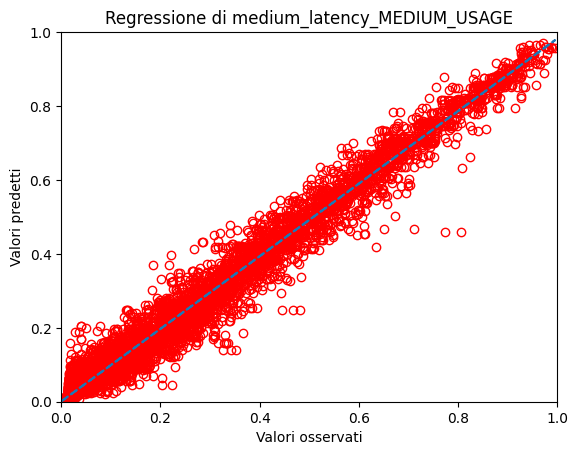

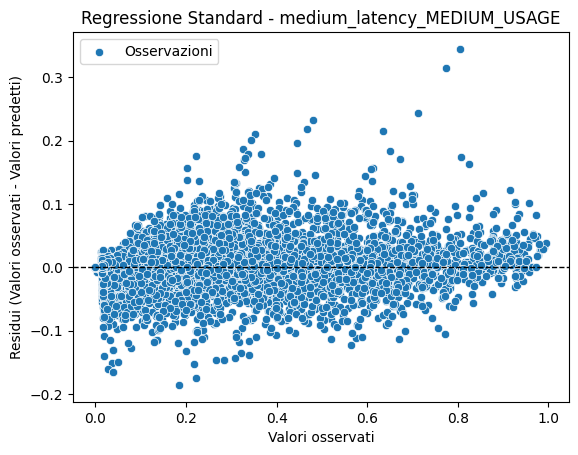

mape: 6.705691458316504e+21
mse: 2.940238506214647e+17
rmse: 542239661.6086513
R-squared score: 0.9870849167577982
Standard deviation: 4715049080.706475
Quantile loss with library:  102439094.1453582
------------------------------
Target: medium_latency_MEDIUM_USAGE quantiles
Prediction for alpha 0.05 are greater than true values in 2.162293488824101 % of cases and less or equal in 97.83770651117591 % of cases.
mape: 0.13770083110901465
mse: 0.015161280319810322
rmse: 0.12313115089127658
R-squared score: 0.47600065662305546
Standard deviation: 0.0659481497886177
Quantile loss with library:  0.002099811136622748
Prediction for alpha 0.95 are greater than true values in 98.3843537414966 % of cases and less or equal in 1.6156462585034015 % of cases.
mape: 4630890325833.335
mse: 0.0037917865626535376
rmse: 0.06157748421828824
R-squared score: 0.868949480047551
Standard deviation: 0.19147016490419766
Quantile loss with library:  0.0015912676605258373


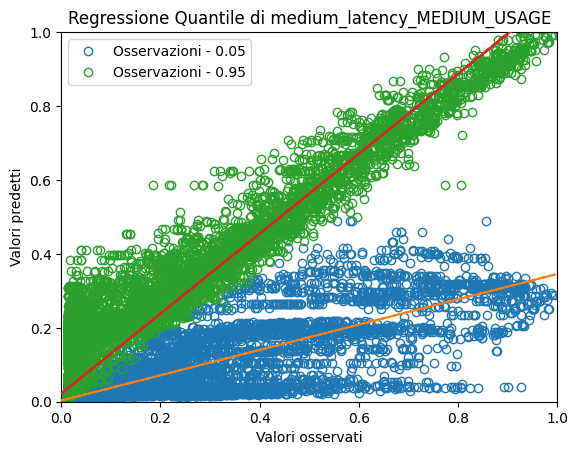

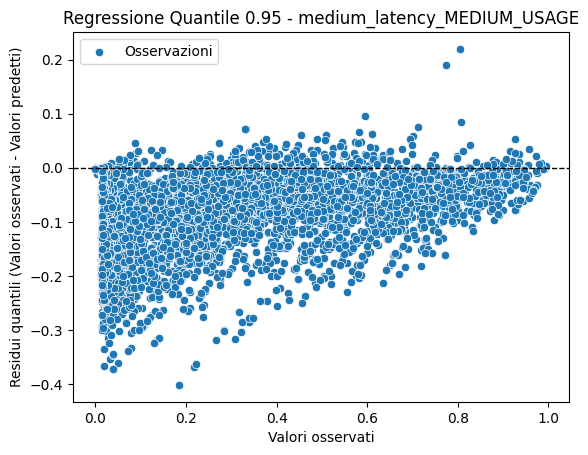

mape: 1.2989863990989545e+23
mse: 2.9834866550805975e+18
rmse: 1727277237.4695954
R-squared score: 0.8689494800475509
Standard deviation: 5370827692.816775
Quantile loss with library:  44635802.25207486
------------------------------
Target: cpu_usage_node
mape: 0.06273817130598802
mse: 0.000859515888854403
rmse: 0.02931750140878999
R-squared score: 0.974785186930287
Standard deviation: 0.182279345128365


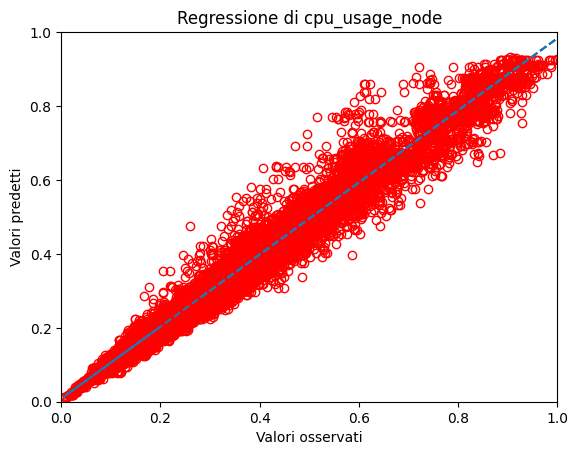

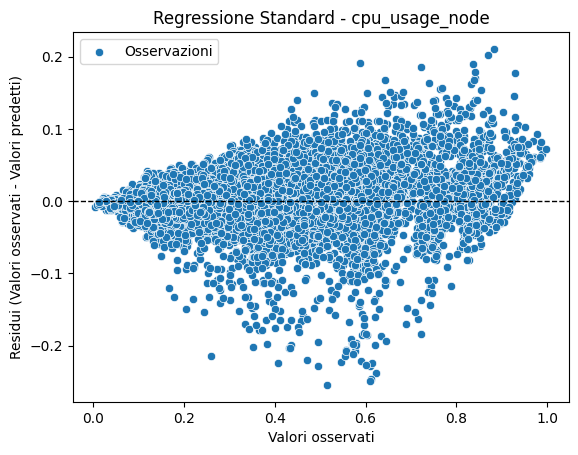

mape: 0.04038905274653901
mse: 150.26069938884876
rmse: 12.258087101536224
R-squared score: 0.974785186930287
Standard deviation: 76.21372838834633
Quantile loss with library:  4.000099677279831
------------------------------
Target: cpu_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 4.919825072886297 % of cases and less or equal in 95.0801749271137 % of cases.
mape: 0.12742217598459868
mse: 0.004754541958866571
rmse: 0.06895318672016959
R-squared score: 0.8605204531067894
Standard deviation: 0.1482931111353572
Quantile loss with library:  0.002678195955863196
Prediction for alpha 0.95 are greater than true values in 95.20975056689342 % of cases and less or equal in 4.790249433106577 % of cases.
mape: 0.18398336817710587
mse: 0.0033733304173592838
rmse: 0.058080378936085496
R-squared score: 0.9010397631980258
Standard deviation: 0.19670238081008673
Quantile loss with library:  0.0028123558102099537


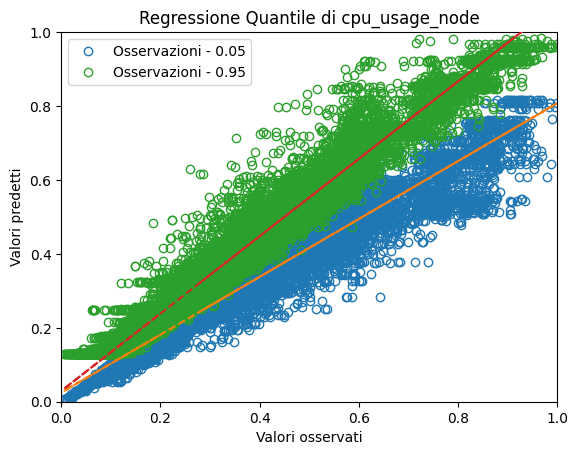

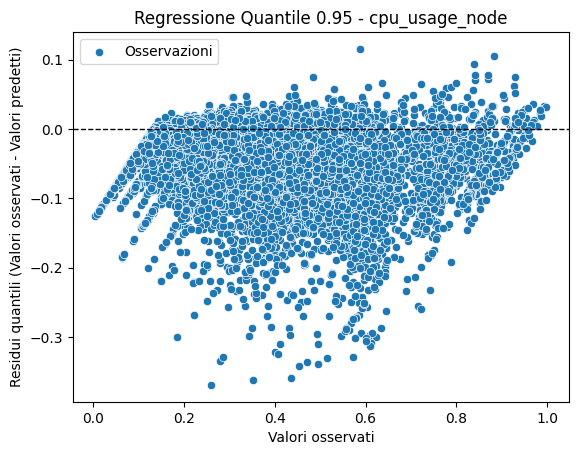

mape: 0.10534934075686234
mse: 589.726140441303
rmse: 24.284277638861383
R-squared score: 0.9010397631980258
Standard deviation: 82.24421595240942
Quantile loss with library:  1.175888149585935
------------------------------
Target: ram_usage_node
mape: 0.10443101607189685
mse: 0.004289286687356877
rmse: 0.06549264605554488
R-squared score: 0.7577253168845576
Standard deviation: 0.11664385511265135


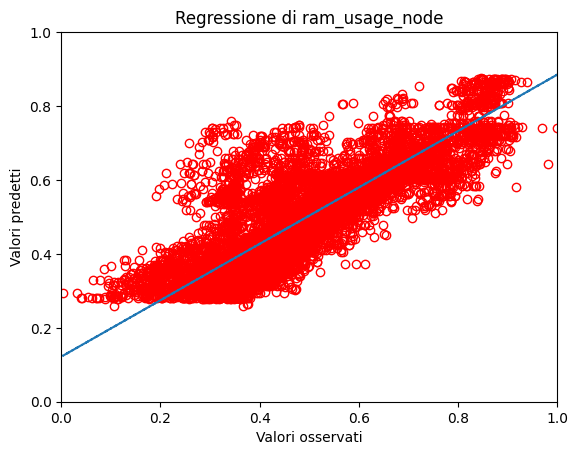

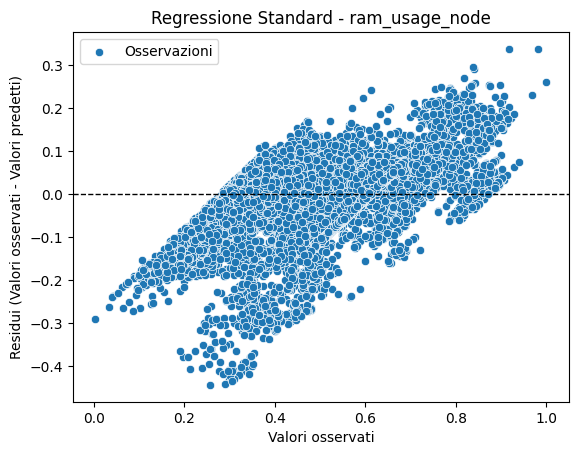

mape: 0.03309923667832718
mse: 4.6973184272355336e+16
rmse: 216732979.19872585
R-squared score: 0.7577253168845575
Standard deviation: 386006242.62987924
Quantile loss with library:  68248618.11398913
------------------------------
Target: ram_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.239714933592484 % of cases and less or equal in 94.76028506640752 % of cases.
mape: 0.22313733302258754
mse: 0.02207000139199833
rmse: 0.14855975697340895
R-squared score: -0.24659482644622943
Standard deviation: 0.11956450583180638
Quantile loss with library:  0.006805609065551024
Prediction for alpha 0.95 are greater than true values in 94.99514091350825 % of cases and less or equal in 5.00485908649174 % of cases.
mape: 0.18385913144529786
mse: 0.010600575755954378
rmse: 0.1029590974899954
R-squared score: 0.40124050470086814
Standard deviation: 0.12414466605930412
Quantile loss with library:  0.004543372785972349


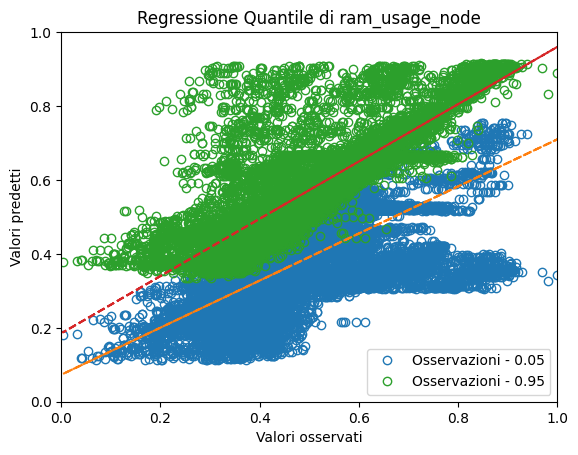

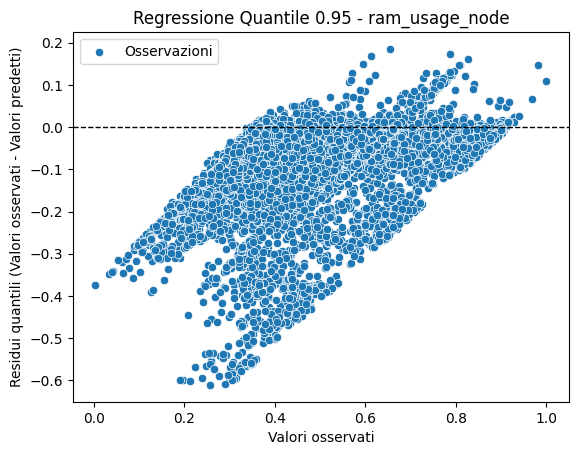

mape: 0.05795181254675869
mse: 1.1608988502569579e+17
rmse: 340719657.5275571
R-squared score: 0.40124050470086814
Standard deviation: 410828466.2043509
Quantile loss with library:  15035256.304640232
------------------------------
Target: power_usage_node
mape: 0.13126776309415167
mse: 0.0014907204359647958
rmse: 0.038609848950297586
R-squared score: 0.9298591440389068
Standard deviation: 0.13974807617501564


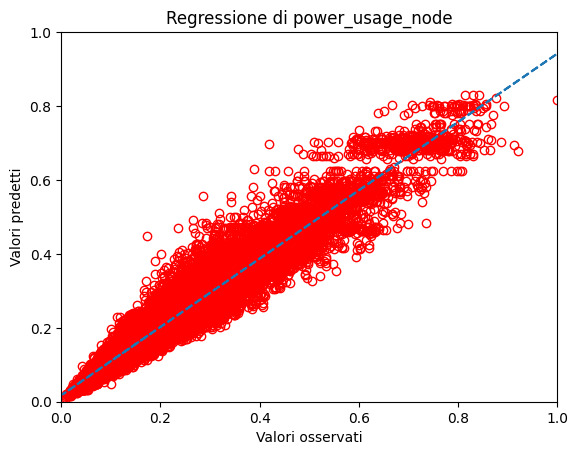

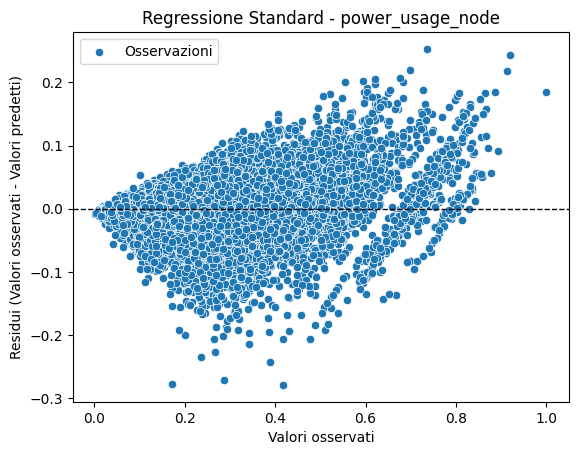

mape: 0.10914437310291149
mse: 23843641286.893814
rmse: 154413.86364861744
R-squared score: 0.9298591440389068
Standard deviation: 558899.8912537611
Quantile loss with library:  55397.17151271146
------------------------------
Target: power_usage_node quantiles
Prediction for alpha 0.05 are greater than true values in 5.057499190152251 % of cases and less or equal in 94.94250080984776 % of cases.
mape: 0.22592395494921824
mse: 0.00567351241309577
rmse: 0.0753227217584161
R-squared score: 0.733051880580899
Standard deviation: 0.11145743638267966
Quantile loss with library:  0.003301696782901967
Prediction for alpha 0.95 are greater than true values in 95.01943634596695 % of cases and less or equal in 4.980563654033042 % of cases.
mape: 0.31337756417142126
mse: 0.005519650185010856
rmse: 0.07429434827098799
R-squared score: 0.7402913522602231
Standard deviation: 0.16353723539539597
Quantile loss with library:  0.0034743532933619674


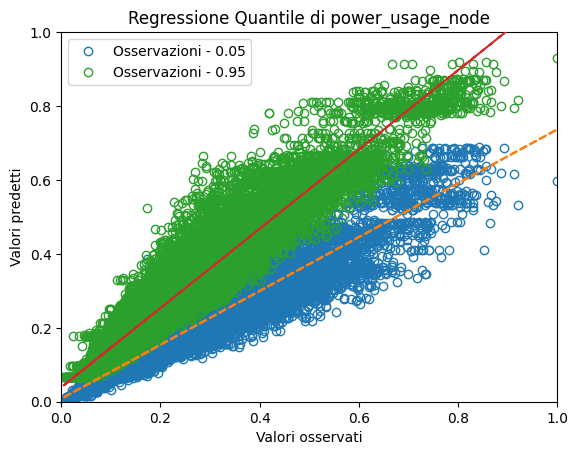

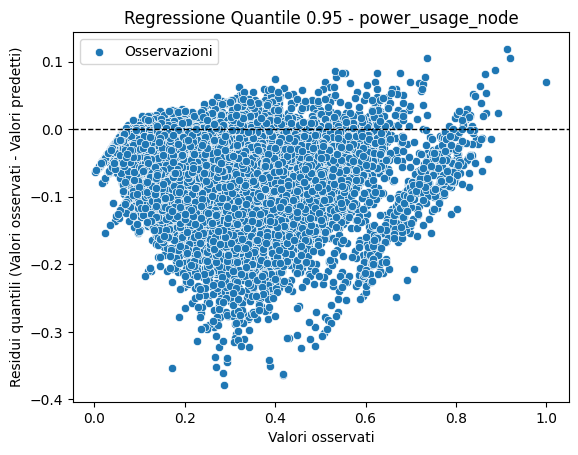

mape: 0.25086552088784186
mse: 88285204834.7742
rmse: 297128.26327156124
R-squared score: 0.740291352260223
Standard deviation: 654040.7966973381
Quantile loss with library:  13895.115632255918
------------------------------
Target: overloaded_node
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97     22627
           1       0.96      0.99      0.98     22743

    accuracy                           0.97     45370
   macro avg       0.98      0.97      0.97     45370
weighted avg       0.98      0.97      0.97     45370

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     22627
         1.0       0.96      0.99      0.98     22743

    accuracy                           0.97     45370
   macro avg       0.98      0.97      0.97     45370
weighted avg       0.98      0.97      0.97     45370

------------------------------


In [35]:
quantiles_string = [str(q) for q in QUANTILES]
all_metrics = {}
all_metrics_no_scale = {}
for target_name, y_pred in all_predictions.items():
    print(f"Target: {target_name}")

    if target_name.startswith('overloaded'):
        task_type = 'binary classification'
    elif target_name.startswith('replica'):
        task_type = 'classification'
    else:
        task_type = 'regression'

    if target_name.endswith('quantiles'):
        # Get the test dataset for the current iteration
        trunc_target = target_name[0:target_name.index(' ')]
        y_test = y_test_dict[trunc_target]
        y_test_df = pd.DataFrame(y_test, columns=[trunc_target])
        y_pred_df = pd.DataFrame(y_pred, columns=quantiles_string)
        for quantile in QUANTILES:
            statistics = (y_pred_df[str(quantile)] > y_test_df[trunc_target]).value_counts(normalize=True)
            if statistics.size > 1:
                true_percentage, false_percentage = statistics[True], statistics[False]
                print(f"Prediction for alpha {quantile} are greater than true values in {true_percentage * 100} % of cases and less or equal in {false_percentage * 100} % of cases.")
            all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df[str(quantile)], quantile) 
        plot_quantile_regression(y_test, y_pred_df, trunc_target)            
        # metrics on non-scaled predictions
        y_test_df_not_scaled = pd.DataFrame()
        for col in y_test_df:
            y_test_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
        y_pred_df_not_scaled = pd.DataFrame()
        for col in y_pred_df:
            y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[trunc_target].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
        all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled[str(quantile)], quantile) 
    else:
        y_test = y_test_dict[target_name]
        y_test_df = pd.DataFrame(y_test, columns=[target_name])
        y_pred_df = pd.DataFrame(y_pred, columns=[target_name])
        all_metrics[target_name] = metrics(task_type, y_test_df, y_pred_df, 0)
        if task_type == 'regression':
            plot_regression(y_test, y_pred, target_name)   
        # metrics on non-scaled predictions
        y_test_df_not_scaled = pd.DataFrame()
        for col in y_test_df:
            y_test_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_test_df[col])).tolist()]
        y_pred_df_not_scaled = pd.DataFrame()
        for col in y_pred_df:
            y_pred_df_not_scaled[col] = [y[0] for y in y_scalers[target_name].inverse_transform(pd.DataFrame(y_pred_df[col])).tolist()]
        all_metrics_no_scale[target_name] = metrics(task_type, y_test_df_not_scaled, y_pred_df_not_scaled, quantile) 

    print("-" * 30)


In [36]:
pd.DataFrame(all_metrics).transpose()

mape       mse  \
cpu_usage_HIGH_USAGE                    164032577718.283691  0.000424   
cpu_usage_HIGH_USAGE quantiles          23584240847553.9375  0.001151   
ram_usage_HIGH_USAGE                    271663664448.889221  0.007771   
ram_usage_HIGH_USAGE quantiles            31559217706.04229  0.029308   
power_usage_HIGH_USAGE                  134083885124.361633  0.000405   
power_usage_HIGH_USAGE quantiles       1088868352226.635864  0.001401   
medium_latency_HIGH_USAGE               507849410118.319885  0.002271   
medium_latency_HIGH_USAGE quantiles      46784012274.319717  0.008435   
cpu_usage_LOW_USAGE                     183380163055.186188  0.000934   
cpu_usage_LOW_USAGE quantiles          8021237499241.294922  0.003483   
ram_usage_LOW_USAGE                     259422399229.925995  0.007168   
ram_usage_LOW_USAGE quantiles          2903543285536.786621  0.030522   
power_usage_LOW_USAGE                   181153887047.050903  0.001806   
power_usage_LOW_USAGE quantiles        4305746121170.540527  0.008126   
medium_latency_LOW_USAGE                 39695809372.485474  0.000496   
medium_latency_LOW_USAGE quantiles       51965584268.278648  0.001484   
cpu_usage_MEDIUM_USAGE                  192761451303.097473  0.000222   
cpu_usage_MEDIUM_USAGE quantiles        667333988372.634644   0.00088   
ram_usage_MEDIUM_USAGE                  736773377569.815674  0.023078   
ram_usage_MEDIUM_USAGE quantiles         43263157024.684906  0.069038   
power_usage_MEDIUM_USAGE                137419041855.866882  0.000558   
power_usage_MEDIUM_USAGE quantiles      132948203072.549744   0.00211   
medium_latency_MEDIUM_USAGE             239058097327.951721  0.000374   
medium_latency_MEDIUM_USAGE quantiles  4630890325833.334961  0.003792   
cpu_usage_node                                     0.062738   0.00086   
cpu_usage_node quantiles                           0.183983  0.003373   
ram_usage_node                                     0.104431  0.004289   
ram_usage_node quantiles                           0.183859  0.010601   
power_usage_node                                   0.131268  0.001491   
power_usage_node quantiles                         0.313378   0.00552   
overloaded_node                                         NaN       NaN   

                                           rmse        r2  \
cpu_usage_HIGH_USAGE                   0.020598  0.987835   
cpu_usage_HIGH_USAGE quantiles         0.033924  0.967004   
ram_usage_HIGH_USAGE                   0.088151  0.622285   
ram_usage_HIGH_USAGE quantiles         0.171196 -0.424603   
power_usage_HIGH_USAGE                 0.020126   0.98236   
power_usage_HIGH_USAGE quantiles       0.037434  0.938973   
medium_latency_HIGH_USAGE               0.04765  0.942277   
medium_latency_HIGH_USAGE quantiles    0.091845  0.785545   
cpu_usage_LOW_USAGE                    0.030558  0.975598   
cpu_usage_LOW_USAGE quantiles          0.059013  0.908995   
ram_usage_LOW_USAGE                    0.084663  0.560644   
ram_usage_LOW_USAGE quantiles          0.174706   -0.8709   
power_usage_LOW_USAGE                  0.042502  0.939964   
power_usage_LOW_USAGE quantiles        0.090146  0.729922   
medium_latency_LOW_USAGE               0.022273  0.748536   
medium_latency_LOW_USAGE quantiles     0.038521  0.247842   
cpu_usage_MEDIUM_USAGE                 0.014905  0.994583   
cpu_usage_MEDIUM_USAGE quantiles       0.029657  0.978554   
ram_usage_MEDIUM_USAGE                 0.151913  0.527384   
ram_usage_MEDIUM_USAGE quantiles       0.262751 -0.413856   
power_usage_MEDIUM_USAGE               0.023629  0.976695   
power_usage_MEDIUM_USAGE quantiles     0.045934  0.911926   
medium_latency_MEDIUM_USAGE            0.019331  0.987085   
medium_latency_MEDIUM_USAGE quantiles  0.061577  0.868949   
cpu_usage_node                         0.029318  0.974785   
cpu_usage_node quantiles                0.05808   0.90104   
ram_usage_node                         0.065493  0.757725   
ram_usage_

In [37]:
pd.DataFrame(all_metrics_no_scale).transpose()

mape           mse  \
cpu_usage_HIGH_USAGE                   6.050260e+13  5.772397e+01   
cpu_usage_HIGH_USAGE quantiles         8.698929e+15  1.565717e+02   
ram_usage_HIGH_USAGE                   1.219956e+20  1.567051e+15   
ram_usage_HIGH_USAGE quantiles         1.417225e+19  5.910340e+15   
power_usage_HIGH_USAGE                 7.888394e+15  1.401991e+06   
power_usage_HIGH_USAGE quantiles       6.406007e+16  4.850191e+06   
medium_latency_HIGH_USAGE              1.501449e+22  1.984604e+18   
medium_latency_HIGH_USAGE quantiles    1.383162e+21  7.373266e+18   
cpu_usage_LOW_USAGE                    1.199551e+13  3.995583e+00   
cpu_usage_LOW_USAGE quantiles          5.246959e+14  1.490136e+01   
ram_usage_LOW_USAGE                    1.033107e+20  1.136734e+15   
ram_usage_LOW_USAGE quantiles          1.156288e+21  4.840532e+15   
power_usage_LOW_USAGE                  2.778565e+16  4.249688e+07   
power_usage_LOW_USAGE quantiles        6.604216e+17  1.911777e+08   
medium_latency_LOW_USAGE               7.575203e+20  1.806587e+17   
medium_latency_LOW_USAGE quantiles     9.916660e+20  5.403720e+17   
cpu_usage_MEDIUM_USAGE                 2.493022e+13  3.715886e+00   
cpu_usage_MEDIUM_USAGE quantiles       8.630764e+13  1.471220e+01   
ram_usage_MEDIUM_USAGE                 2.133217e+20  1.934610e+15   
ram_usage_MEDIUM_USAGE quantiles       1.252620e+19  5.787488e+15   
power_usage_MEDIUM_USAGE               1.781038e+16  9.378341e+06   
power_usage_MEDIUM_USAGE quantiles     1.723093e+16  3.544232e+07   
medium_latency_MEDIUM_USAGE            6.705691e+21  2.940239e+17   
medium_latency_MEDIUM_USAGE quantiles  1.298986e+23  2.983487e+18   
cpu_usage_node                         4.038905e-02  1.502607e+02   
cpu_usage_node quantiles               1.053493e-01  5.897261e+02   
ram_usage_node                         3.309924e-02  4.697318e+16   
ram_usage_node quantiles               5.795181e-02  1.160899e+17   
power_usage_node                       1.091444e-01  2.384364e+10   
power_usage_node quantiles             2.508655e-01  8.828520e+10   
overloaded_node                                 NaN           NaN   

                                               rmse        r2  quantile_loss  \
cpu_usage_HIGH_USAGE                   7.597629e+00  0.987835   1.489174e+00   
cpu_usage_HIGH_USAGE quantiles         1.251286e+01  0.967004   4.001952e-01   
ram_usage_HIGH_USAGE                   3.958599e+07  0.622285   8.948012e+06   
ram_usage_HIGH_USAGE quantiles         7.687874e+07 -0.424603   1.892223e+06   
power_usage_HIGH_USAGE                 1.184057e+03  0.982360   2.354468e+02   
power_usage_HIGH_USAGE quantiles       2.202315e+03  0.938973   6.001775e+01   
medium_latency_HIGH_USAGE              1.408760e+09  0.942277   2.532644e+08   
medium_latency_HIGH_USAGE quantiles    2.715376e+09  0.785545   6.370003e+07   
cpu_usage_LOW_USAGE                    1.998895e+00  0.975598   6.911829e-01   
cpu_usage_LOW_USAGE quantiles          3.860228e+00  0.908995   1.769497e-01   
ram_usage_LOW_USAGE                    3.371549e+07  0.560644   1.035449e+07   
ram_usage_LOW_USAGE quantiles          6.957393e+07 -0.870900   3.601847e+06   
power_usage_LOW_USAGE                  6.518963e+03  0.939964   2.034041e+03   
power_usage_LOW_USAGE quantiles        1.382670e+04  0.729922   5.831209e+02   
medium_latency_LOW_USAGE               4.250397e+08  0.748536   4.544909e+07   
medium_latency_LOW_USAGE quantiles     7.351000e+08  0.247842   2.176674e+07   
cpu_usage_MEDIUM_USAGE                 1.927663e+00  0.994583   4.347275e-01   
cpu_usage_MEDIUM_USAGE quantiles       3.835648e+00  0.978554   1.111120e-01   
ram_usage_MEDIUM_USAGE                 4.398421e+07  0.527384   1.150561e+07   
ram_usage_MEDIUM_USAGE quantiles       7.607554e+07 -0.413856   2.165935e+06   
power_usage_MEDIUM_USAGE               3.062408e+03  0.976695   6.492113e+02   
power_usage_MEDIUM_USAGE quantiles     5.953345e+03  0.911926   1.849344e+02  